# Library

In [1]:
!pip install biopython
!pip install odfpy
!pip install pandas-ods-reader
!apt-get install -y cd-hit

import os
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO
from collections import Counter
import re
import pandas as pd
import math
from pandas_ods_reader import read_ods
import networkx as nx
import json
import time
import requests, sys

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 1.8 MB/s eta 0:00:001.8 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 36.0 MB/s eta 0:00:00m eta 0:00:010:0101
  Created wheel for ezodf: filename=ezodf-0.3.2-py2.py3-none-any.whl size=49003 sha256=fedee709cf6827717083b5fd9e321d56c1907c04332e114924c7bd80396e787a
  Stored in directory: /home/maksymilian/.cache/pip/wheels/19/dd/9d/ccbb47390cefc7c40c72647c87ec8f681977e2dc7ebf33506a
Successfully built ezodf
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/v

# Functions
Code blocks below contains all function used to analyse datasets downloaded from two data bases: PHISTO and HPI-DB 3.0.

## General functions

In [2]:
def digit_length(number):
    count = 0
    while number > 0:
        number /= 10
        count += 1
    return count

def to_histogram(data , title, x_label, y_label, divide, language): #Variable "divide" dictates a number of bars on the plot
    plt.figure(figsize=(16, 12))
    data = np.array(data)

    if all(isinstance(x, str) for x in data):
        label_counts = Counter(data)
        cleaned_counts = {}
        if(language == "POL"):
            exec_label = "Inne"
        else:
            exec_label = "Inne"

        for label, count in label_counts.items():
            found_match = re.search(r"\((.*?)\)", label)
            str_name = found_match.group(1) if found_match else label

            if count < 10 and len(list(label_counts.keys())) > 40:
                cleaned_counts[exec_label] = cleaned_counts.get(exec_label, 0) + count
            else:
                cleaned_counts[str_name] = count

        sorted_counts = dict(sorted(filter(lambda x: x[0] != exec_label, cleaned_counts.items()), key = lambda x: x[1], reverse = True))
        #Filter function returns a dict object, which in this example is missing a pair with exec label
        if exec_label in cleaned_counts:
            sorted_counts[exec_label] = cleaned_counts[exec_label]

        labels = list(sorted_counts.keys())
        counts = list(sorted_counts.values())
        n = len(labels)
        max_count = max(counts)
        bigplot = 0

        if n > 40:
            x_pos = np.arange(n) * 1.5
            width = 0.5
            angle = 90
            font = 12
            bigplot = 1
        else:
            x_pos = np.arange(n)
            width = 0.6
            angle = 0
            font = 17

        plt.bar(labels, counts, width = width, align = 'center', color = 'skyblue', edgecolor = 'black')
        if bigplot:
            plt.xlim([x_pos[0] - 1, x_pos[-1] + 1])
        plt.xticks(x_pos, labels, rotation = 90, fontsize = font)

        for i, count in enumerate(counts):
            offset = 0.006 * max_count + 10 * math.log10(max(count, 10))
            if offset > max_count * 0.1:
                offset = max_count * 0.05
            rotation = 0 if count < 10 or count == max_count else angle
            plt.text(x_pos[i],
                     count + offset, str(count),
                     ha = 'center', va = 'bottom',
                     rotation = rotation, fontsize = 16)
        plt.ylim(0, max_count * 1.1)
    else:
        counts, bins, patches = plt.hist(data,
                                         bins = int(max(data)/divide),
                                         colot = 'skyblue',
                                         edgecolor = 'black')
        max_count = max(counts)
        plt.ylim(top = max_count * 1.15)
        plt.xticks(fontsize = 17)
        for count, bin in zip(counts, bins):
            label = f"{int(count)}" if count != 0 else ''
            rotation = 0 if count < 10 or count == max_count else 90
            offset = 0.025 * max_count if count > 10 else 0.01 * max_count
            plt.text(bin + 0.2,
                     count + offset,
                     label,
                     na = 'left',
                     rotation = rotation,
                     fontsize = 16)

    plt.yticks(fontsize = 20)
    plt.xlabel(x_label, fontsize = 25)
    plt.ylabel(y_label, fontsize = 25)
    plt.title(title, fontsize = 25)
    plt.tight_layout()
    plt.show()
    plt.close()

def to_bar_plot(x_args, y_args, title, x_label, y_label):
    n = len(x_args)
    max_count = max(y_args)
    bigplot = 0
    if n > 40:
        x_pos = np.arange(n) * 1.5
        width = 0.5
        angle = 90
        font = 15
        bigplot = 1
    else:
        x_pos = np.arange(n)
        width = 0.6
        angle = 0
        font = 20
    plt.figure(figsize = (16, 12))
    plt.bar(x_args, y_args, width = width, align = 'center', color = 'skyblue', edgecolor = 'black')
    if bigplot:
        plt.xlim([x_pos[0] - 1, x_pos[-1] + 1])
    plt.xticks(x_pos, x_args, rotation = 30, fontsize = font)
    for i, count in enumerate(y_args):
        offset = 0.006 * max_count + 10 * math.log10(max(count, 10))
        if offset > max_count * 0.1:
            offset = max_count * 0.05
        rotation = 0 if count < 10 or count == max_count else angle
        plt.text(x_pos[i],
                 count + offset, str(count),
                 ha = 'center', va = 'bottom',
                 rotation = rotation, fontsize = 16)
    plt.ylim(0, max_count * 1.1)
    plt.yticks(fontsize = 20)
    plt.xlabel(x_label, fontsize = 25)
    plt.ylabel(y_label, fontsize = 25)
    plt.title(title, fontsize = 25)
    plt.tight_layout()
    plt.show()
    plt.close()

def ids_to_list(ids_file):
    ids_list = []
    ids_set = set()
    with open(ids_file, 'r') as f:
        for line in f:
            ids = line.strip().split('\t')
            ids_set.add(ids[0])
            if len(ids) > 1:
                ids_set.add(ids[1])
    ids_list = list(ids_set)
    return ids_list

## Tabular format functions

In [3]:
def rows_count(filepath):
    if os.path.isfile(filepath):
        file_extension = os.path.splitext(filepath)[1]
        if file_extension.lower() == '.ods':
            df = pd.read_excel(filepath, engine = 'odf')
            return len(df)
        else:
            i = 0
            with open(filepath, 'r') as f:
                for line in f:
                    if line.strip():
                        i += 1
            return i
    else:
        raise FileNotFoundError(f"File '{filepath}' not found.")

def method_info(table_path, database, language):
    data = pd.read_excel(table_path, engine = 'odf', sheet_name = 0)
    values = data['detection_method'].dropna().tolist() # Downloaded dataset requires setting common name for specific column to work

    if(language == "POL"):
        plot_title = f"Ilościowa liczba metod identyfikacyjnych interakcji w {database}"
        x_label = "Eksperymentalne metody identyfikacji"
        y_label = "Liczba interakcji"
        exec_label = "Inne"
    else:
        plot_title = f"Number of detection methods in {database}"
        x_label = "Experimental detection methods"
        y_label = "Number of interactions"
        exec_label = "Other"

    to_histogram(values, plot_title, x_label, y_label, 1, language)

def info_ids_tabular(table_path, ids_file, database):
    data = pd.read_excel(table_path, engine = 'odf', sheet_name = 0)
    with open(ids_file, 'w') as f:
        if (database == "PHISTO"):
            ids = data[["Uniprot ID", "Uniprot ID.1"]]
            for pair in ids.values:
                pathogen, host = map(str.strip, pair)
                if pathogen and host:
                    f.write(f"{host}\t{pathogen}\n")

        elif (database == "HPIDB3"):
            ids = data[["# protein_xref_1", "protein_xref_2"]]
            for pair in ids.values:
                col1, col2 = map(str.strip, pair)
                host = re.search(r"\buniprotkb:([^\| ]+)\b", col1)
                pathogen = re.search(r"\buniprotkb:([^\| ]+)\b", col2)
                if host and pathogen:
                    f.write(f"{host.group(1)}\t{pathogen.group(1)}\n")

## FASTA format functions

In [4]:
def count_fasta_records(fasta_file):
    with open(fasta_file, 'r') as f:
        record_count = sum(1 for _ in SeqIO.parse(f, 'fasta')) # _ sign marks object which would not be modified
    return record_count

def info_ids_fasta(fasta_file, filter = None):
    id_set = set()
    for record in SeqIO.parse(fasta_file, 'fasta'):
        if filter is not None:
            if filter in record.description:
                header = record.description
                fasta_id_match = re.search(r"\|([A-Z0-9]+)\|", header)
            if fasta_id_match:
                id_set.add(fasta_id_match.group(1))
        else:
            header = record.description
            fasta_id_match = re.search(r"\|([A-Z0-9]+)\|", header)
            if fasta_id_match:
                id_set.add(fasta_id_match.group(1))
    return id_set

def extract_ids_fasta(fasta_file, output_file):
    ids = info_ids_fasta(fasta_file)
    with open(output_file, 'w') as f:
        for id in ids:
            f.write(f"{id}\n")

def filter_ids_fasta(input_file, fasta_infile, output_file):
    active_ids = info_ids_fasta(fasta_infile)

    with open(input_file, 'r', encoding = 'utf-8') as infile, open(output_file, 'w', encoding = 'utf-8') as outfile:
        for line in infile:
            columns = line.strip().split('\t')
            if len(columns) == 2 and columns[0] in active_ids and columns[1] in active_ids:
                outfile.write(f"{columns[0]}\t{columns[1]}\n")

def cd_hit_format(input_fasta, input_ids, output_fasta):
    fasta_dict = {}
    for record in SeqIO.parse(input_fasta, 'fasta'):
        id_match = re.search(r"\|([A-Z0-9]+)\|", record.description)
        if id_match:
            fasta_dict[id_match.group(1)] = str(record.seq)
    with open(input_ids, 'r') as idfile, open(output_fasta, 'w') as outfile:
        for pairs in idfile:
            ids = pairs.strip().split('\t')
            id1, id2 = ids
            if id1 in fasta_dict and id2 in fasta_dict:
                seq1 = fasta_dict[id1]
                seq2 = fasta_dict[id2]
                if seq1 and seq2:
                    header = f">{id1}&{id2}"
                    combined_seq = seq1 + seq2
                outfile.write(f"{header}\n{combined_seq}\n")
            else:
                print(f"Warning: One or both IDs ({id1} or {id2}) not found in the input FASTA file")
    return output_fasta

## JSON format functions

In [5]:
def json_map(ids_list):
    base_url = "https://www.ebi.ac.uk/proteins/api/proteins?accession="
    headers = { "Accept": "application/json" }
    all_data = []
    chunk_size = 100

    for i in range(0, len(ids_list), chunk_size):
        chunk = ids_list[i:i + chunk_size]
        url = base_url + ",".join(chunk)
        response = requests.get(url, headers = headers)

        if response.status_code == 200:
            data = response.json()
            all_data.extend(data)
        else:
            print(f"Error {response.status_code}: {response.text}")

    return all_data

def count_json_records(json_file):
    with open(json_file, 'r') as i:
        data = json.load(i)
    if isinstance(data, list):
        return len(data)
    else:
        return len(data["results"])

def extract_uniparcIds_json(json_file, output_uniparc_ids, output_inactive_json):
    with open(json_file, 'r') as i:
        data = json.load(i)
    inactive_clean = []
    inactive = []
    for record in data["results"]:
        if record["to"]["entryType"] == "Inactive":
            inactive.append(str(record["from"]))
            if("Redundant" in str(record["to"]["inactiveReason"]["deletedReason"])):
                inactive_clean.append(record)
    with open(output_inactive_json, 'w') as o:
        json.dump(inactive_clean, o, indent = 4)
    uniparc_dict = {}
    with open(output_uniparc_ids, 'w') as o:
        for record in inactive_clean:
            uniprot_id = str(record["from"])
            uniparc_id = str(record["to"]["extraAttributes"]["uniParcId"])
            o.write(f"{uniparc_id}\n")
            uniparc_dict[uniparc_id] = uniprot_id
    return inactive, uniparc_dict

def plot_inactivationReason_json(json_file, dataset, language):
    with open(json_file, 'r') as i:
        data = json.load(i)
        reason = []
        if isinstance(data, list):
            for record in data:
                if record["to"]["entryType"] == "Inactive":
                    reason.append(str(record["to"]["inactiveReason"]["deletedReason"]))
        else:
            for record in data["results"]:
                if record["to"]["entryType"] == "Inactive":
                    reason.append(str(record["to"]["inactiveReason"]["deletedReason"]))

        to_histogram(reason, f"Ilościowa analiza powodów deaktywacji rekordów w UniProt z {dataset}", "Powód deaktywacji", "Ilość rekordów", 1, language)


def uniparc_to_ref_uniprot(uniparc_json, dict_ids, output_file):
    ref_ids = []
    with open(uniparc_json, 'r') as i, open(output_file, 'w') as o:
        data = json.load(i)
        for record in data["results"]:
            entry_id = dict_ids.get(record["from"])
            if entry_id is None:
                print(f"Warning: Missing 'from' ID: {record['from']}")
                continue
            for tax in record["to"]["commonTaxons"]:
                if tax["topLevel"] == "cellular organisms":
                    entry_tax_id = tax["commonTaxonId"]
            ref_ids.clear()
            for ids in record["to"]["uniProtKBAccessions"]:
                if not re.search(r"\.\d+$", ids):
                    ref_ids.append(ids)
            if(len(ref_ids) != 0):
                uniprot_ids = list(set(ref_ids))
                result = json_map(uniprot_ids)
                for inner_record in result:
                    id = inner_record["accession"]
                    tax_id = inner_record["organism"]["taxonomy"]
                    if tax_id == entry_tax_id:
                        o.write(f"{entry_id}\t{entry_tax_id}\t{id}\t{tax_id}\n")

def plot_taxonomy(json_file, database, language, level, Type=None):
    tax = []
    with open(json_file, 'r') as i:
        data = json.load(i)
    for record in data["results"]:
        if Type is not None and record["to"]["organism"]["lineage"][0] != Type:
            continue
        else:
            if level == -1:
                tax.append(record["to"]["organism"]["scientificName"])
            else:
                tax.append(record["to"]["organism"]["lineage"][level])
    if (language == "POL"):
        plot_title = f"Rozkład taksonomiczny białek z bazy {database}"
        x_label = "Nazwa taksonu"
        y_label = "Liczba wystąpień"
    else:
        plot_title = f"Taxonomy histogram from {database}"
        x_label = "Organism type"
        y_label = "Number of records"
    to_histogram(tax, plot_title, x_label, y_label, 1, language)

def format_json(json_file):
    with open(json_file, 'r') as i:
        data = json.load(i)
    with open(json_file, 'w') as o:
        json.dump(data, o, indent = 4)

# Datasets analysis

In this colab file we will work with two datasets containing protein-protein interactions acquired from two databases: PHISTO database and HPIdb 3.0 database.
Each of those datasets was downloaded as a **.ods files**.

---

In the first steps of this analysis we will focus on obtaining two important aspects of those datasets:

1.   Proteins with active Uniprot IDs
2.   Pair of proteins in which the host is human

After that we will move to:
1. Filtering taxonomy data
2. Reducing number of similar protein sequences
3. Merging datasets
4. Generating taxonomy raport

---

However, before all of that, let's start with analysing type of experimental methods that were used to determine PPIs included in original datasets.

## Detection methods

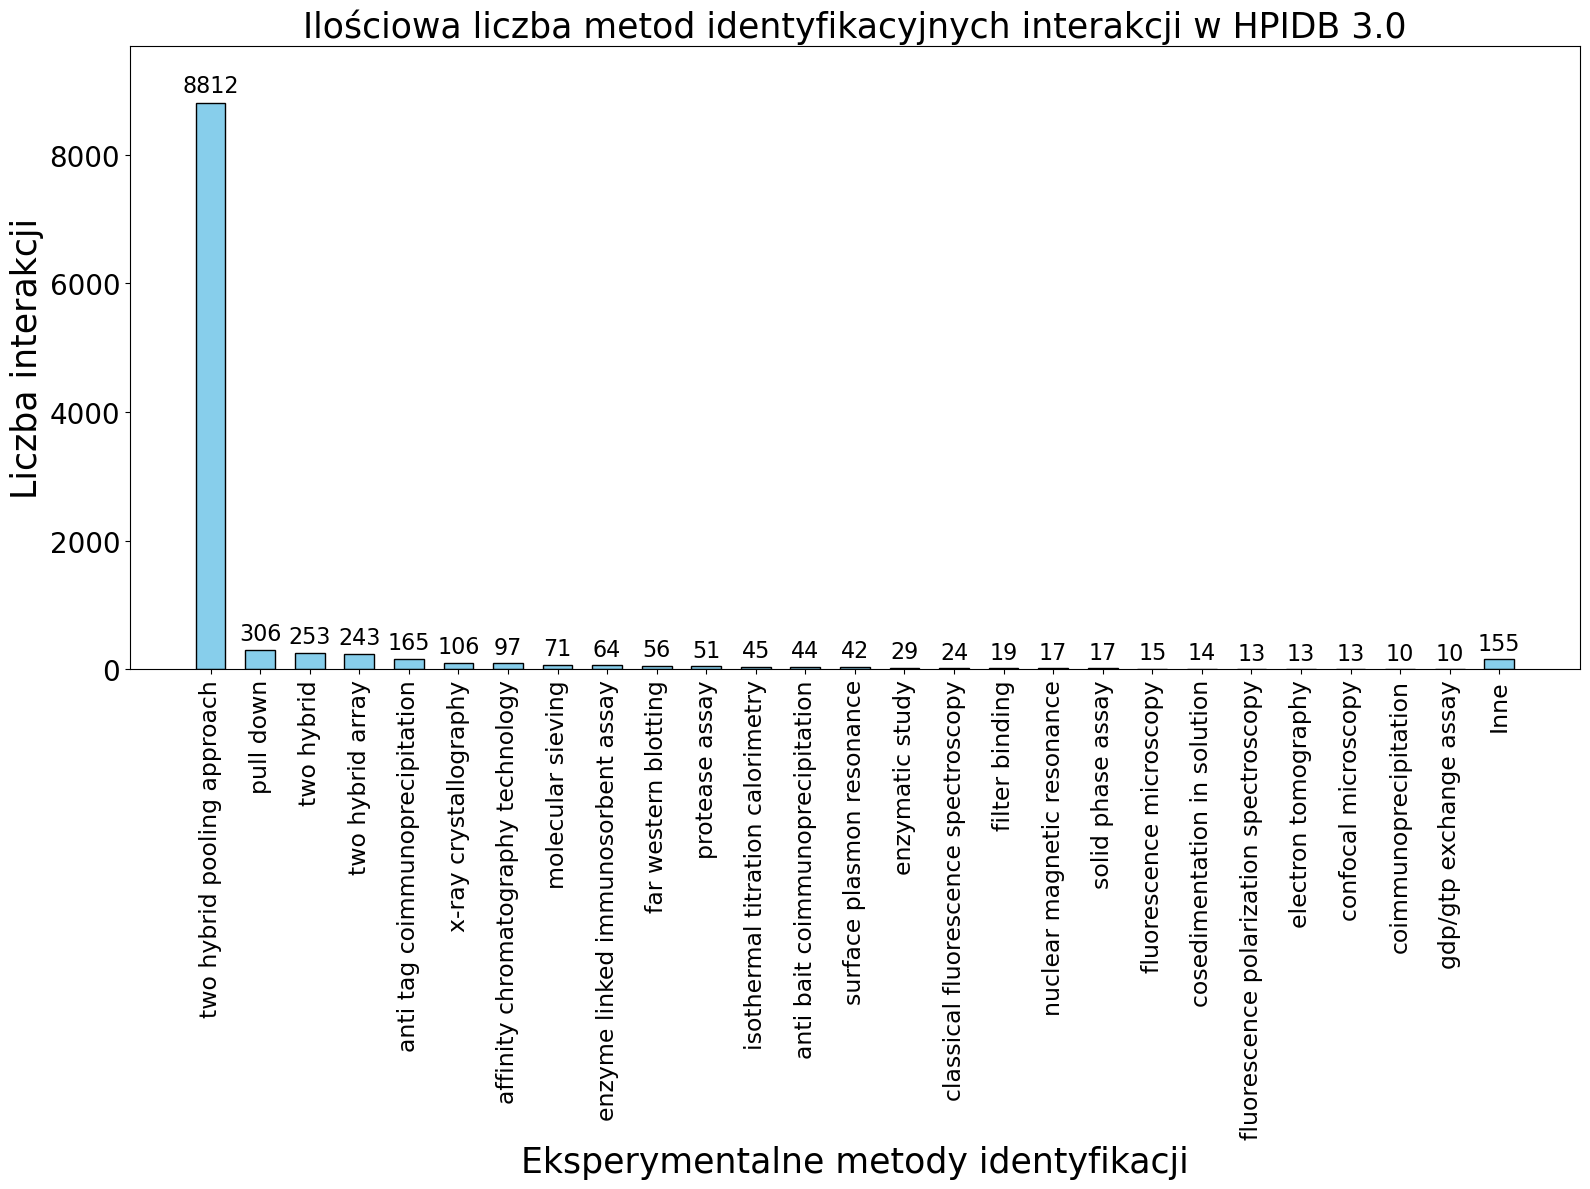

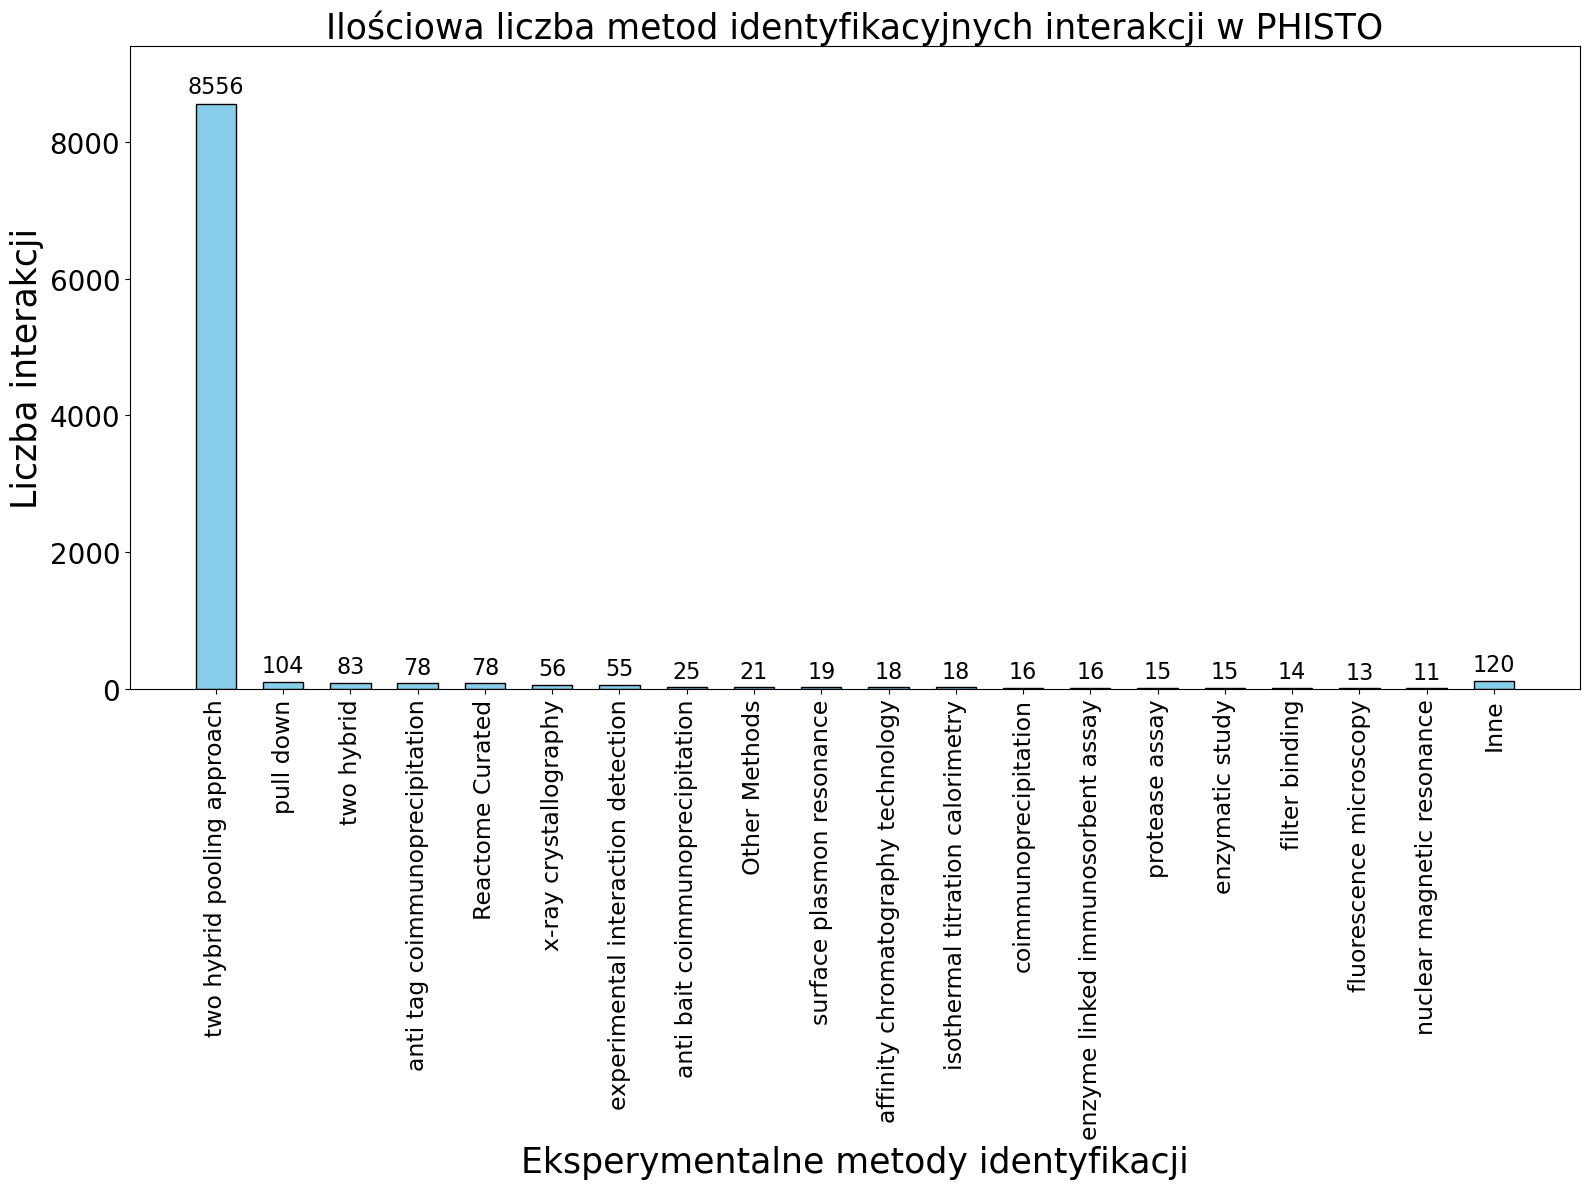

In [6]:
hpidb_table = "../datasets/HPIDB3/hpidb3_bacteria_db.ods"
phisto_table = "../datasets/PHISTODB/phisto_human_bacteria_db.ods"

method_info(hpidb_table, "HPIDB 3.0", "POL")
method_info(phisto_table, "PHISTO", "POL")

## Uniprot IDs
This section provides us with formatting available data into text files, replacing inactive Uniprot IDs with active references and then mapping them to JSON files.

### Creating IDs from table format

In [7]:
print("PHISTO dataset")
phisto_ids_file = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot.txt"
info_ids_tabular(phisto_table, phisto_ids_file, "PHISTO")
print(f"Number of interactions: {rows_count(phisto_ids_file)}")
print("-----------------------------------------------------------------------------")
print("HPI-DB dataset")
hpidb_ids_file = "../datasets/HPIDB3/IDs_files/hpidb3_bacteria_id_uniprot.txt"
info_ids_tabular(hpidb_table, hpidb_ids_file, "HPIDB3")
print(f"Number of interactions: {rows_count(hpidb_ids_file)}")
print("-----------------------------------------------------------------------------")

PHISTO dataset
Number of interactions: 9333
-----------------------------------------------------------------------------
HPI-DB dataset
Number of interactions: 10459
-----------------------------------------------------------------------------


### Extracting inactive Uniprot IDs

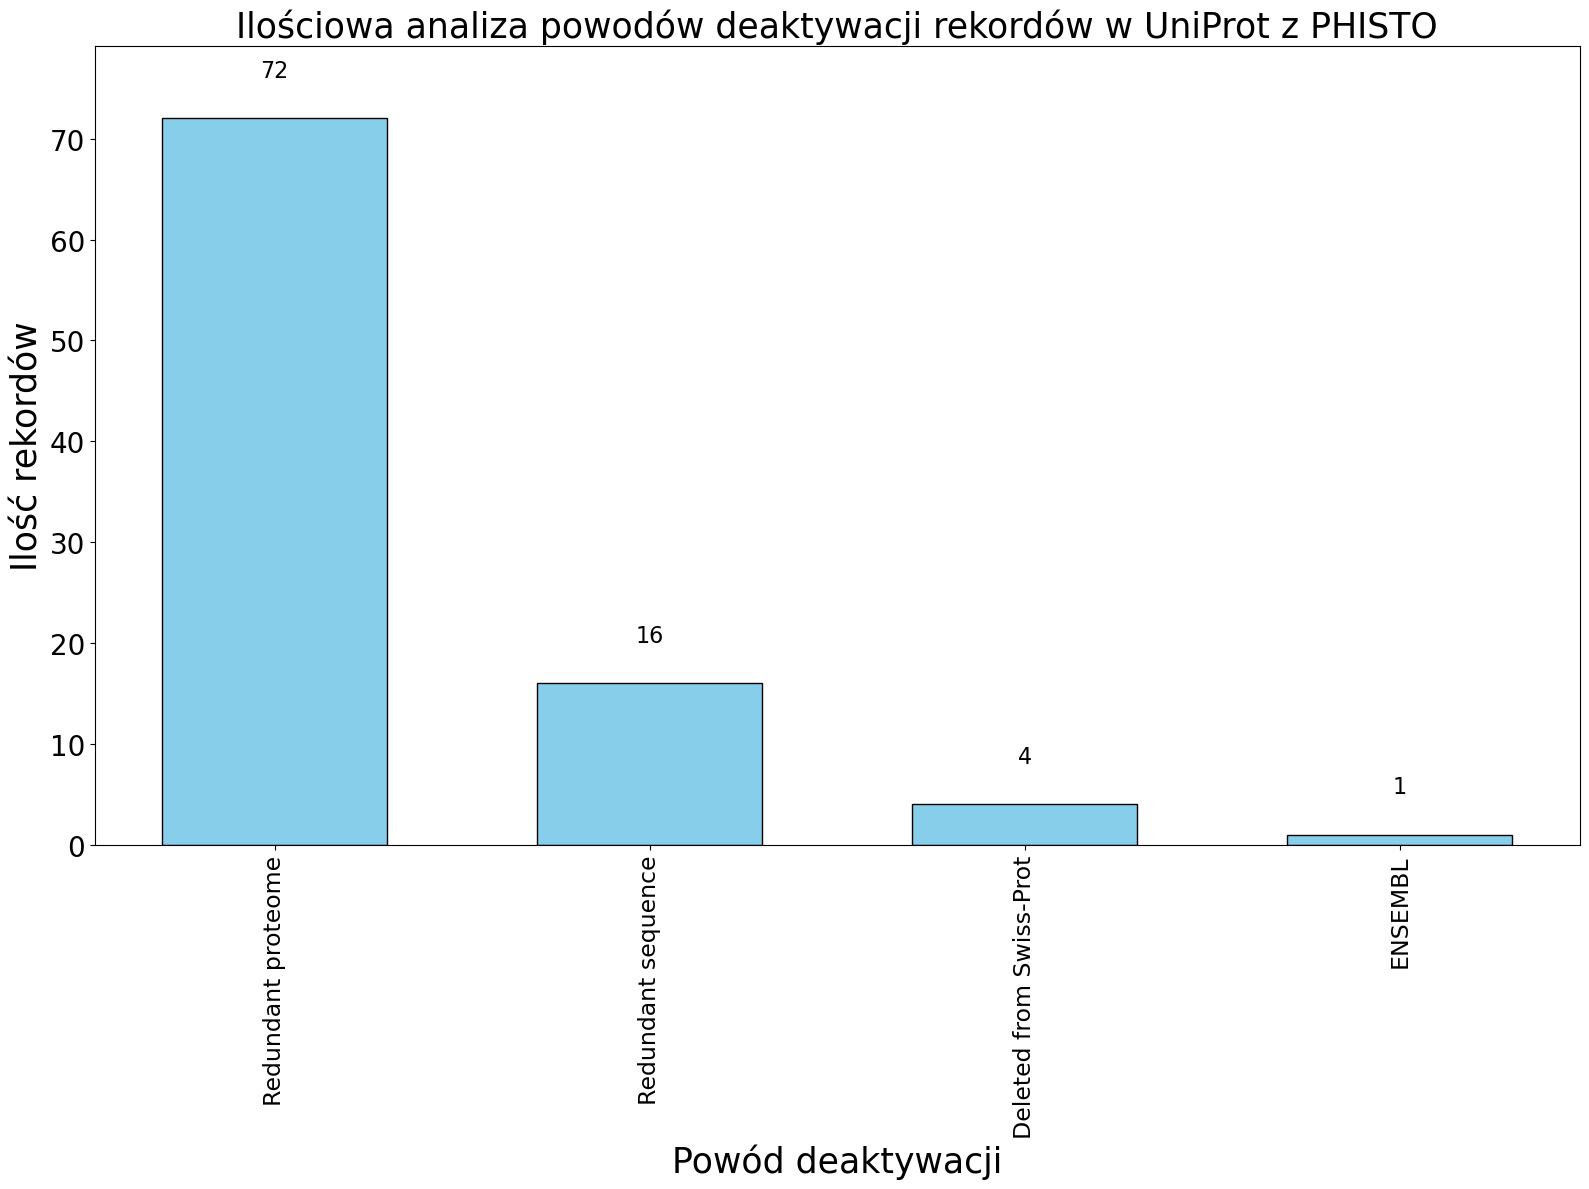

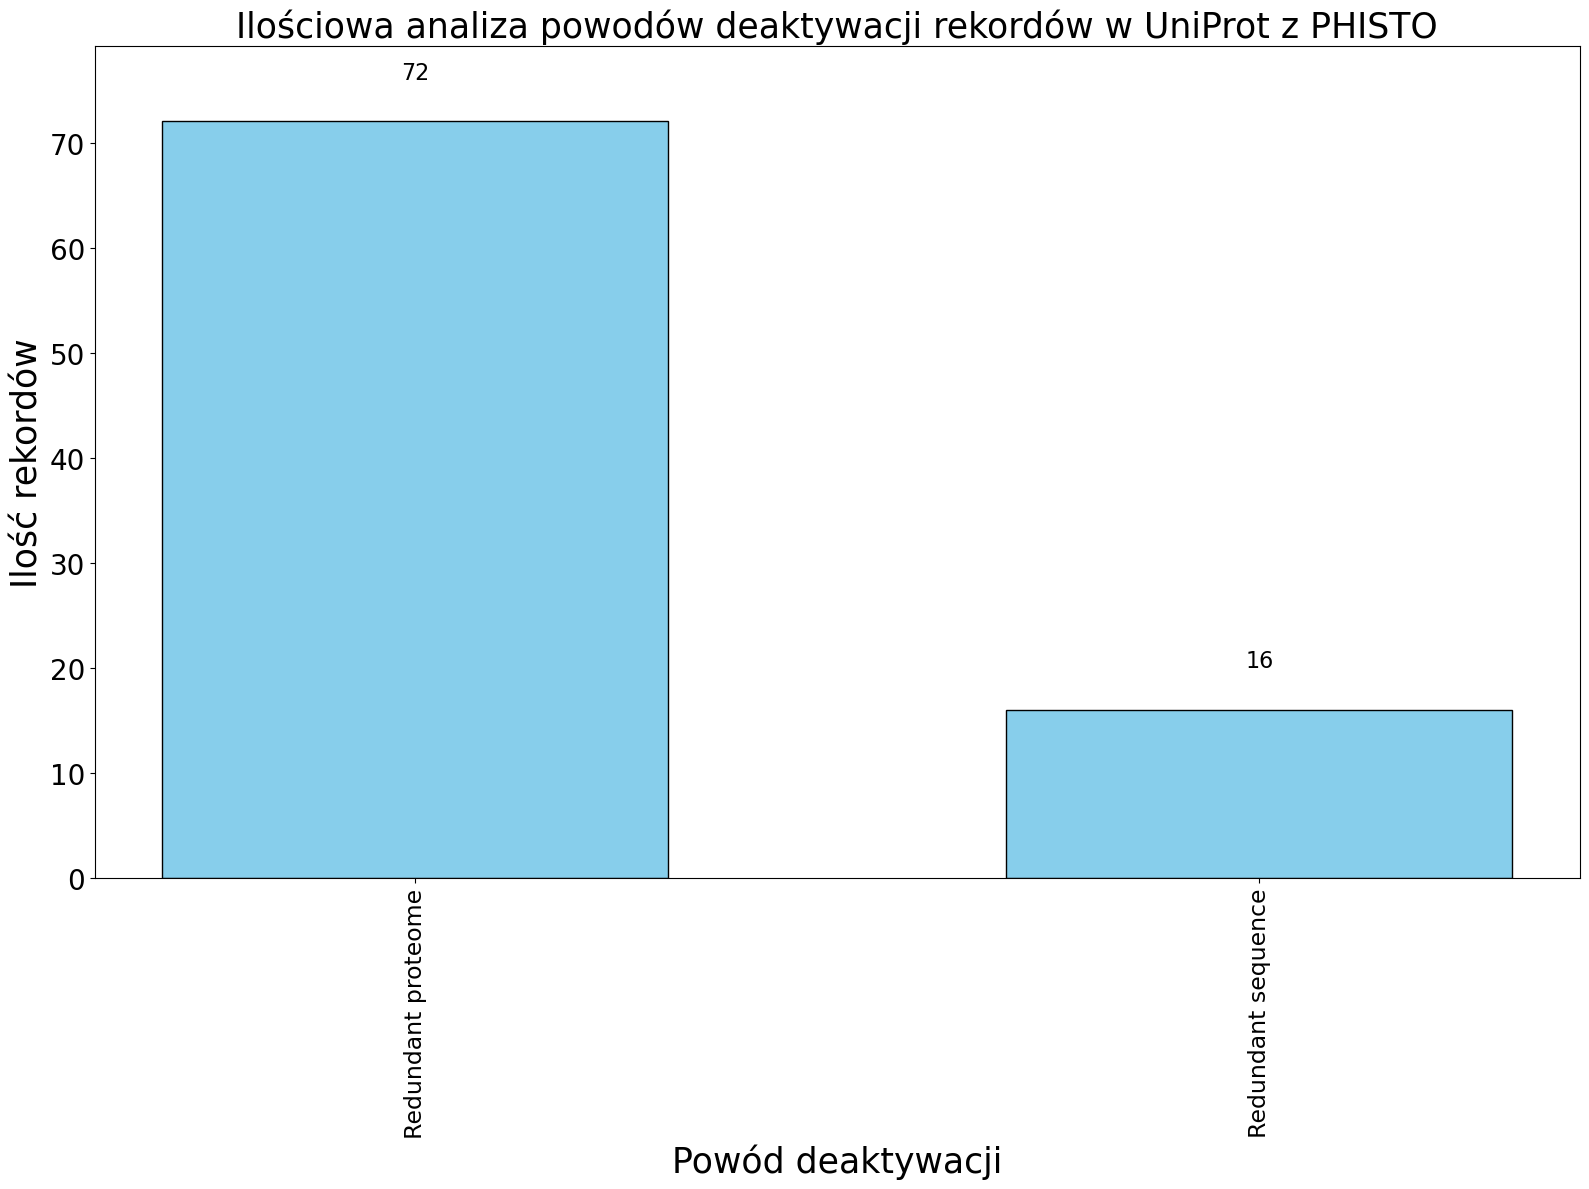

Number of inactive ids in PHISTO dataset: 93
Number of inactive ids deleted because of redundancy: 88
Number of inactive ids with active reference in PHISTO dataset: 38


In [8]:
phisto_ids_file = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot.txt"
phisto_json = "../datasets/PHISTODB/ID_map/phisto_human_bacteria_id_uniprot.json"
phisto_uniparc_ids = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniparc.txt"
phisto_json_inactive = "../datasets/PHISTODB/ID_map/phisto_human_bacteria_id_uniprot_inactive.json"

phisto_inact, phisto_uniparc_dict = extract_uniparcIds_json(phisto_json, phisto_uniparc_ids, phisto_json_inactive)
plot_inactivationReason_json(phisto_json, "PHISTO", "POL")
plot_inactivationReason_json(phisto_json_inactive, "PHISTO", "POL")
#Uniprot ID Mapping: phisto_uniparc_ids -> phisto_json_uniparc
phisto_json_uniparc = "../datasets/PHISTODB/ID_map/phisto_human_bacteria_id_uniparc_map.json"
phisto_uniparc_ref = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot_inactive_ref.txt"
uniparc_to_ref_uniprot(phisto_json_uniparc, phisto_uniparc_dict, phisto_uniparc_ref)
print(f"Number of inactive ids in PHISTO dataset: {len(phisto_inact)}")
print(f"Number of inactive ids deleted because of redundancy: {len(phisto_uniparc_dict)}")
print(f"Number of inactive ids with active reference in PHISTO dataset: {rows_count(phisto_uniparc_ref)}")

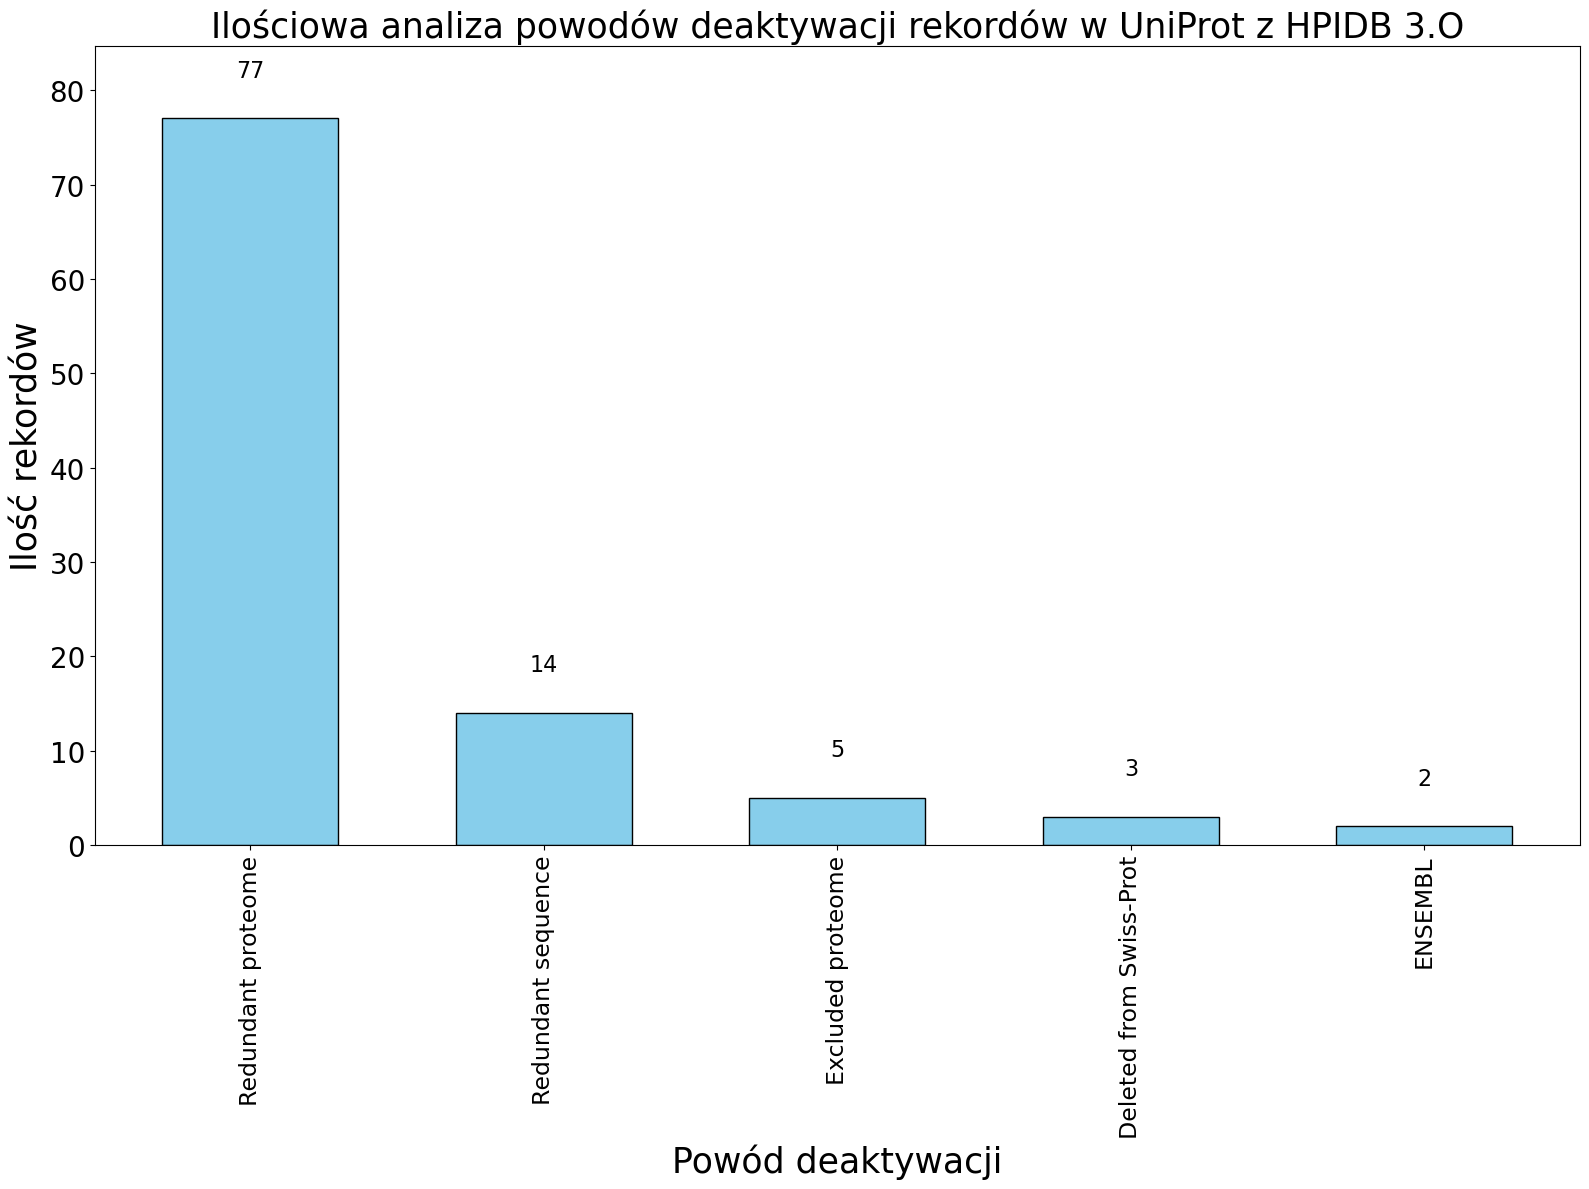

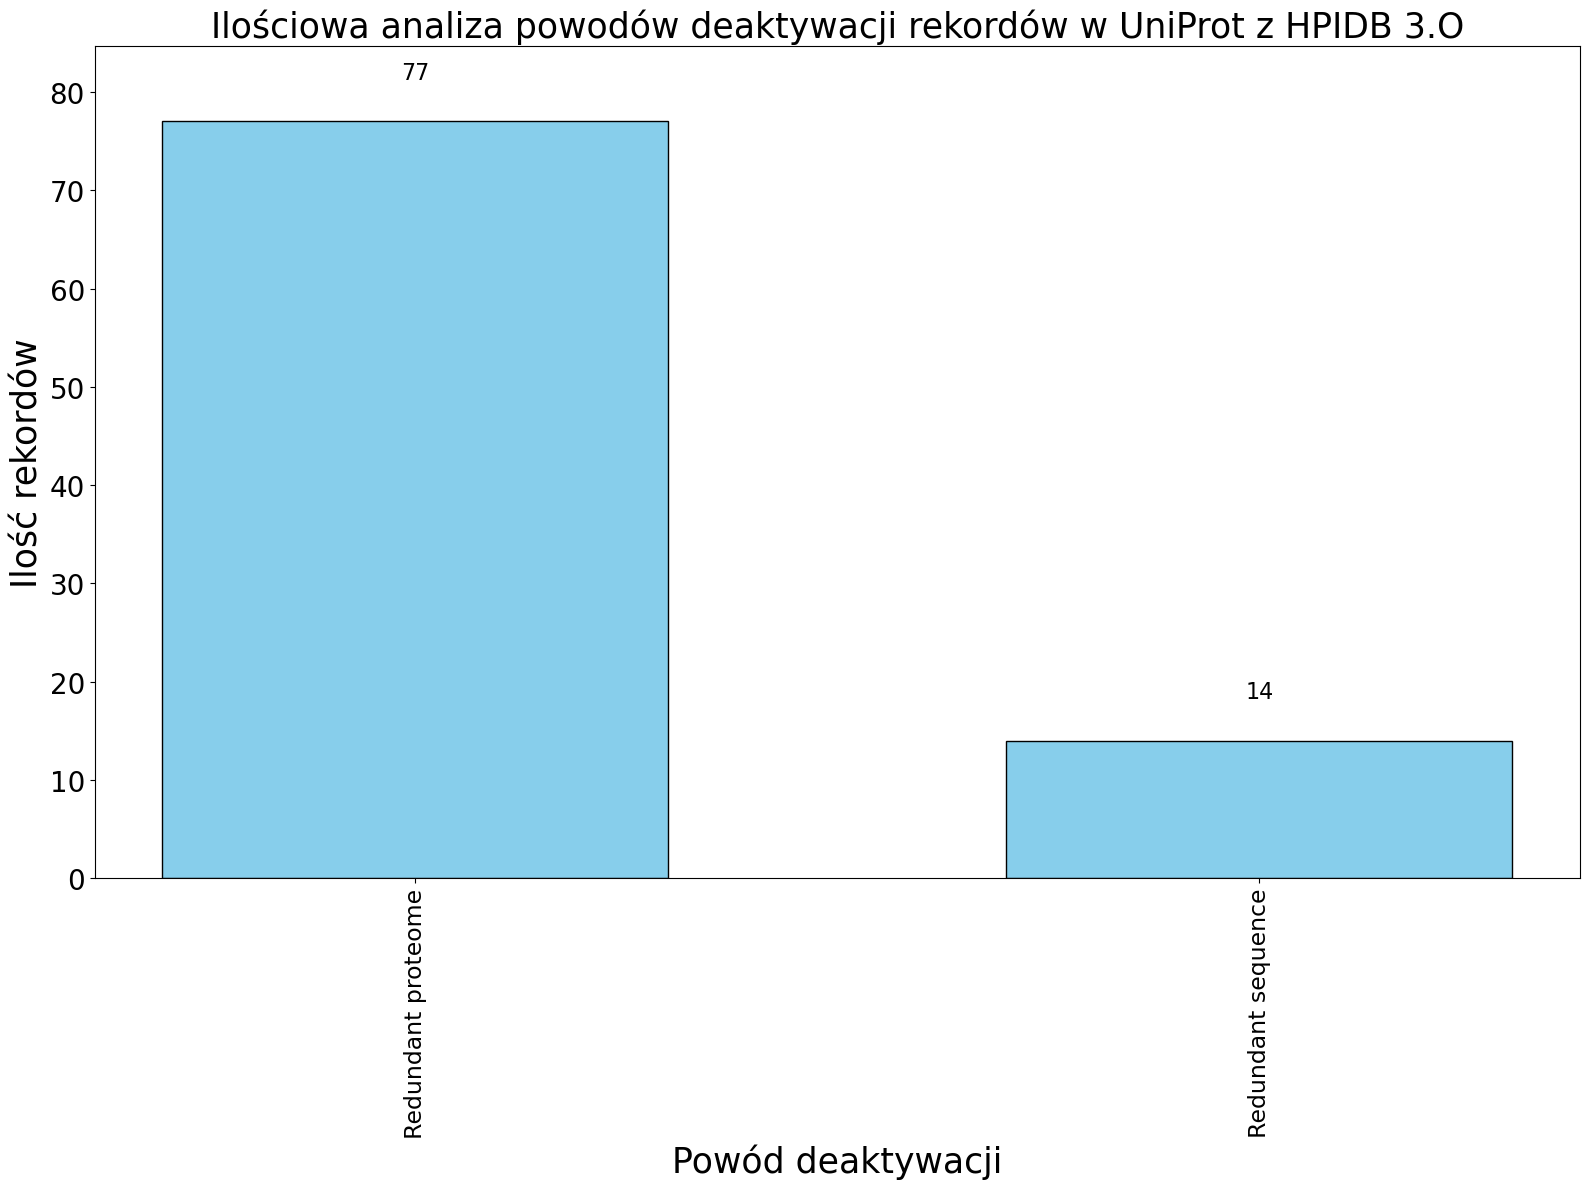

Number of inactive ids in HPIDB 3.0 dataset: 101
Number of inactive ids deleted because of redundancy: 91
Number of inactive ids with active reference in HPIDB 3.0 dataset: 38


In [9]:
hpidb3_ids_file = "../datasets/HPIDB3/IDs_files/hpidb3_bacteria_id_uniprot.txt"
hpidb3_json = "../datasets/HPIDB3/ID_map/hpidb3_bacteria_id_uniprot.json"
hpidb3_uniparc_ids = "../datasets/HPIDB3/IDs_files/hpidb3_bacteria_id_uniparc.txt"
hpidb3_json_inactive = "../datasets/HPIDB3/ID_map/hpidb3_bacteria_id_uniprot_inactive.json"

hpidb3_inact, hpidb3_uniparc_dict = extract_uniparcIds_json(hpidb3_json, hpidb3_uniparc_ids, hpidb3_json_inactive)
plot_inactivationReason_json(hpidb3_json, "HPIDB 3.O", "POL")
plot_inactivationReason_json(hpidb3_json_inactive, "HPIDB 3.O", "POL")
#Uniprot ID Mapping: hpidb3_uniparc_ids -> hpidb3_json_uniparc
hpidb3_json_uniparc = "../datasets/HPIDB3/ID_map/hpidb3_bacteria_id_uniparc_map.json"
hpidb3_uniparc_ref = "../datasets/HPIDB3/IDs_files/hpidb3_bacteria_id_uniprot_inactive_ref.txt"
uniparc_to_ref_uniprot(hpidb3_json_uniparc, hpidb3_uniparc_dict, hpidb3_uniparc_ref)
print(f"Number of inactive ids in HPIDB 3.0 dataset: {len(hpidb3_inact)}")
print(f"Number of inactive ids deleted because of redundancy: {len(hpidb3_uniparc_dict)}")
print(f"Number of inactive ids with active reference in HPIDB 3.0 dataset: {rows_count(hpidb3_uniparc_ref)}")

### Replacing inactive IDs with active references

In [10]:
print(f"Number of PPI in PHISTO dataset: {rows_count(phisto_ids_file)}")
replacement_dict = {}
for id in phisto_inact:
    replacement_dict[id] = ""
print(f"Number of inactive ids in PHISTO dataset: {len(replacement_dict)}")
with open(phisto_uniparc_ref, 'r') as i1:
    for line in i1:
        columns = line.strip().split("\t")
        inactive_id = columns[0]
        active_id = columns[2]
        replacement_dict[inactive_id] = active_id
phisto_ids_active_file = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot_active.txt"
with open(phisto_ids_file, 'r') as i, open(phisto_ids_active_file, 'w') as o:
    for line in i:
        columns = line.strip().split("\t")
        if "_" in columns[0] or "_" in columns[1]:
            continue
        else:
            if columns[0] in replacement_dict:
                active_id_1 = replacement_dict[columns[0]]
                if active_id_1 == "":
                    continue
                columns[0] = active_id_1
            if columns[1] in replacement_dict:
                active_id_2 = replacement_dict[columns[1]]
                if active_id_2 == "":
                    continue
                columns[1] = active_id_2
            if columns[0] != "" and columns[1] != "":
                o.write(f"{columns[0]}\t{columns[1]}\n")
print(f"Number of PPI in PHISTO redacted dataset: {rows_count(phisto_ids_active_file)}")

Number of PPI in PHISTO dataset: 9333
Number of inactive ids in PHISTO dataset: 93
Number of PPI in PHISTO redacted dataset: 9130


In [11]:
print(f"Number of PPI in HPIDB 3.0 dataset: {rows_count(hpidb3_ids_file)}")
replacement_dict = {}
for id in hpidb3_inact:
    replacement_dict[id] = ""
print(f"Number of inactive ids in HPIDB 3.0 dataset: {len(replacement_dict)}")
with open(hpidb3_uniparc_ref, 'r') as i1:
    for line in i1:
        columns = line.strip().split("\t")
        inactive_id = columns[0]
        active_id = columns[2]
        replacement_dict[inactive_id] = active_id
hpidb3_ids_active_file = "../datasets/HPIDB3/IDs_files/hpidb3_bacteria_id_uniprot_active.txt"
with open(hpidb3_ids_file, 'r') as i, open(hpidb3_ids_active_file, 'w') as o:
    for line in i:
        columns = line.strip().split("\t")
        if "_" in columns[0] or "_" in columns[1]:
            continue
        else:
            if columns[0] in replacement_dict:
                active_id_1 = replacement_dict[columns[0]]
                if active_id_1 == "":
                    continue
                columns[0] = active_id_1
            if columns[1] in replacement_dict:
                active_id_2 = replacement_dict[columns[1]]
                if active_id_2 == "":
                    continue
                columns[1] = active_id_2
            if columns[0] != "" and columns[1] != "":
                o.write(f"{columns[0]}\t{columns[1]}\n")
print(f"Number of PPI in HPIDB 3.0 redacted dataset: {rows_count(hpidb3_ids_active_file)}")

Number of PPI in HPIDB 3.0 dataset: 10459
Number of inactive ids in HPIDB 3.0 dataset: 101
Number of PPI in HPIDB 3.0 redacted dataset: 10245


### Mapping cleaned IDs to JSON
> Mapping was conducted using an ID Mapping functionality on Uniprot site.

In [12]:
phisto_active_json = "../datasets/PHISTODB/ID_map/phisto_human_bacteria_id_uniprot_active.json"
hpidb3_active_json = "../datasets/HPIDB3/ID_map/hpidb3_bacteria_id_uniprot_active.json"
format_json(phisto_active_json)
format_json(hpidb3_active_json)
print(f"Number of proteins in redacted PHISTO dataset: {count_json_records(phisto_active_json)}")
print(f"Number of proteins in redacted HPIDB 3.0 dataset: {count_json_records(hpidb3_active_json)}")

Number of proteins in redacted PHISTO dataset: 6353
Number of proteins in redacted HPIDB 3.0 dataset: 7033


## Organisms from which proteins originate
Since the aim of this project is to study the interactions of human proteins with proteins of bacterial pathogens, it was necessary to analyze and ensure consistency in this aspect.

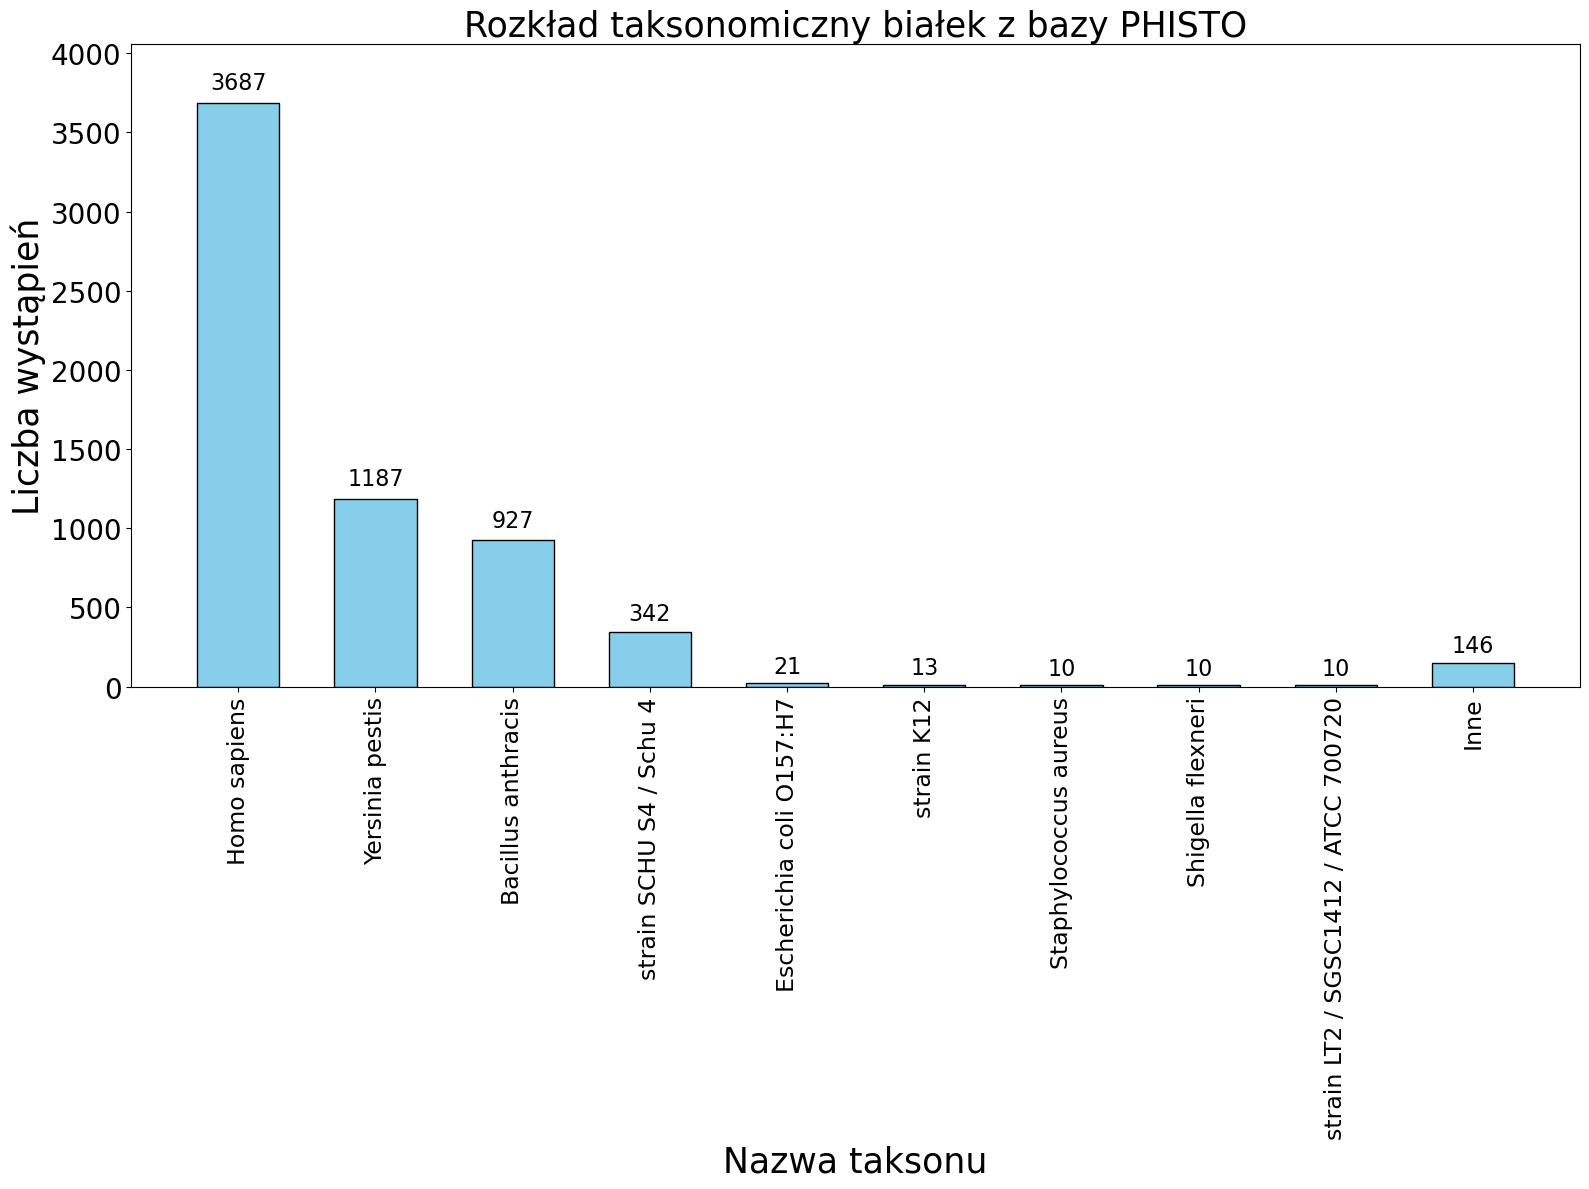

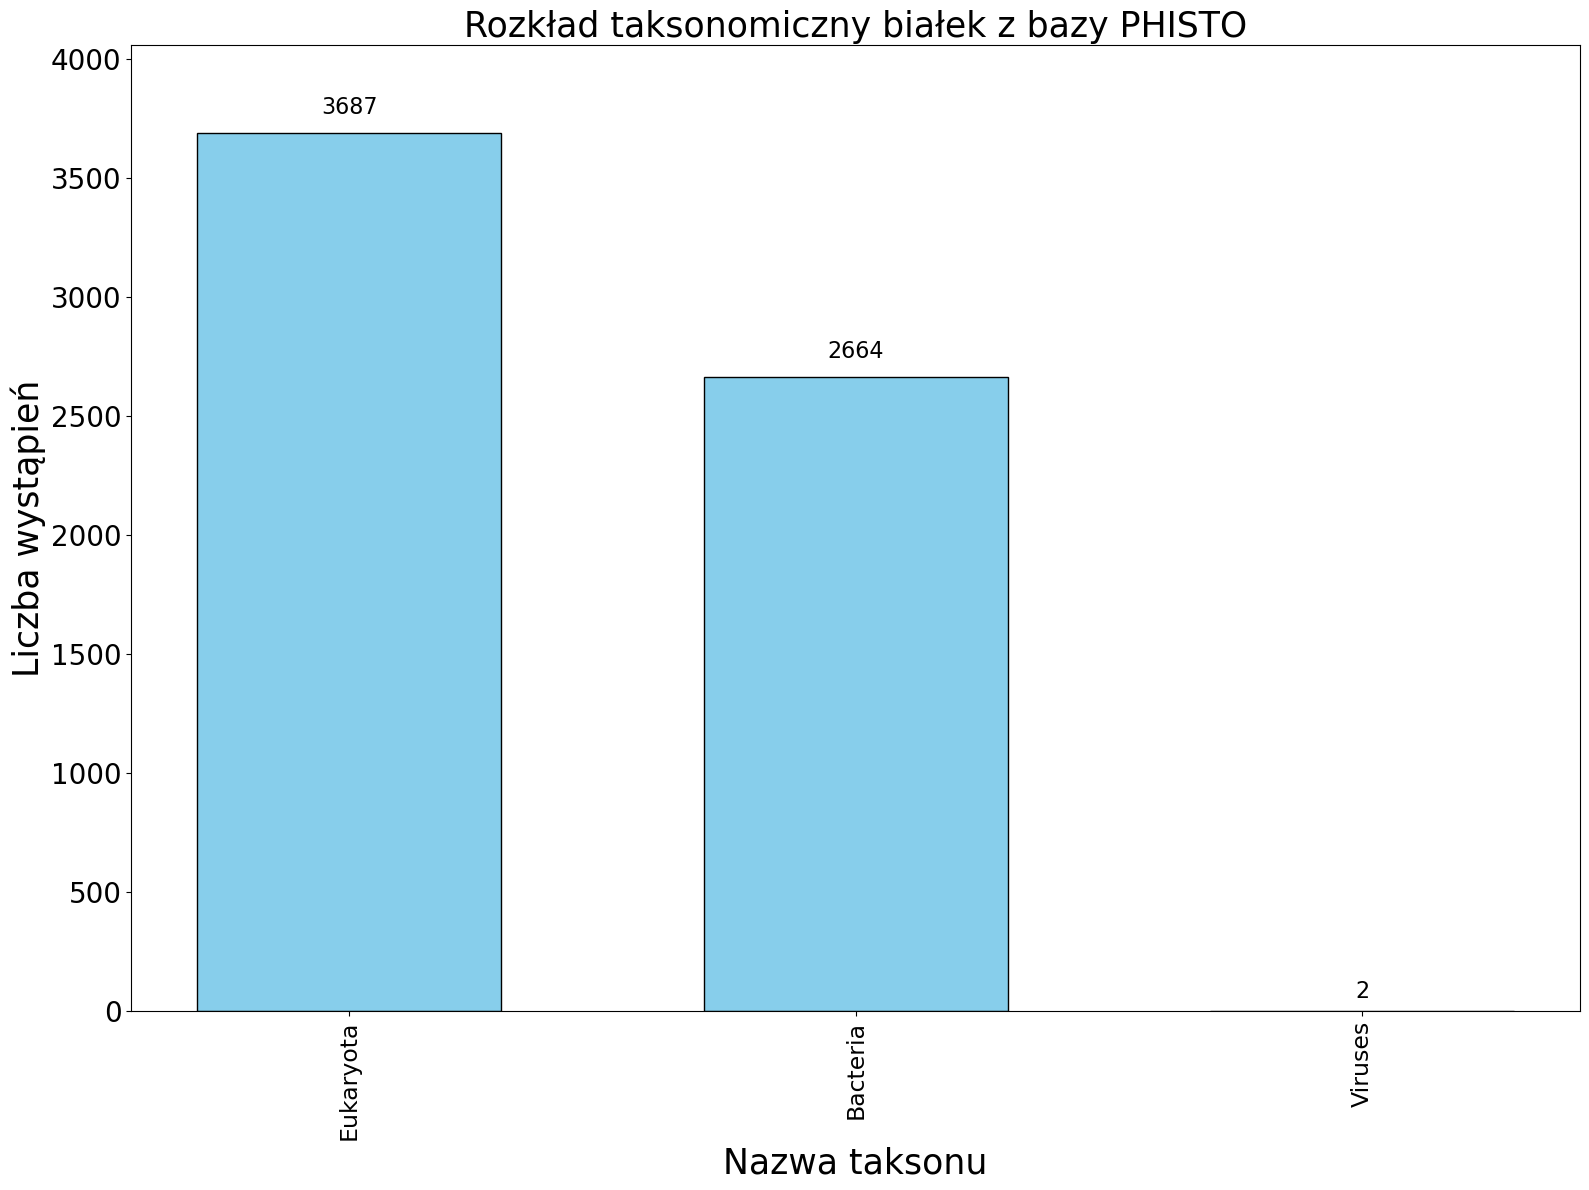

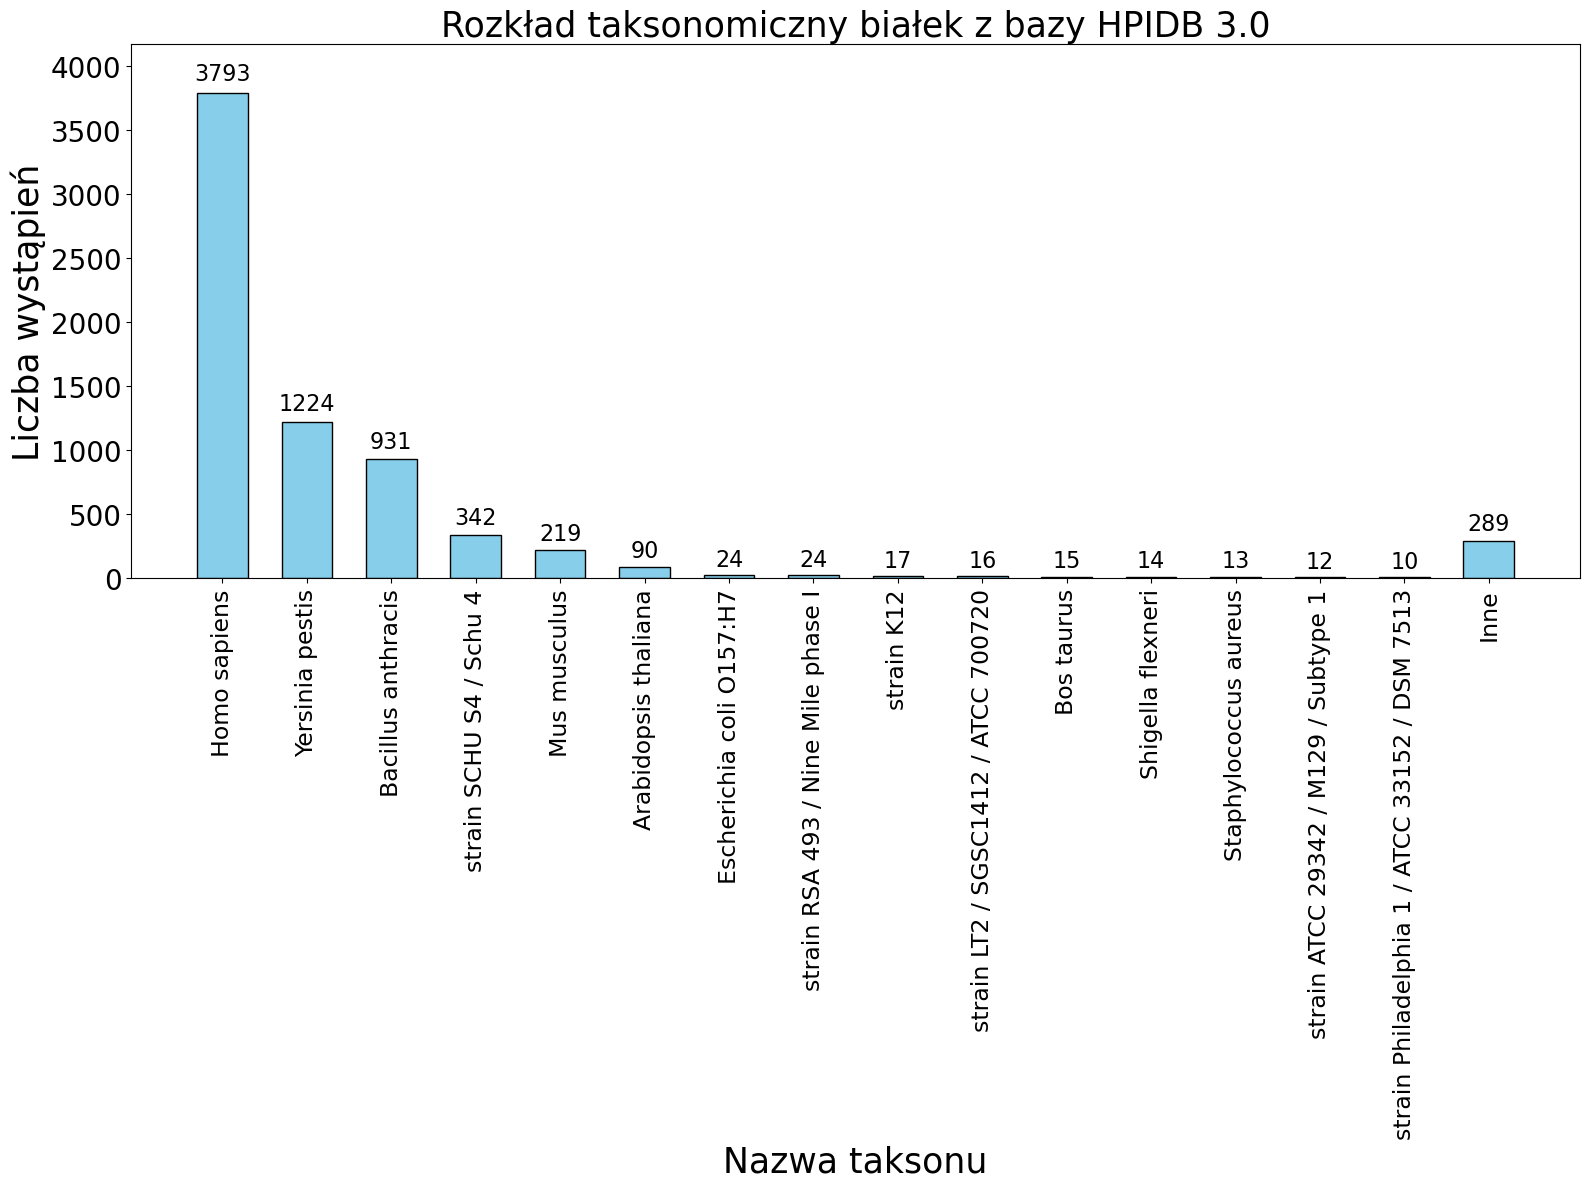

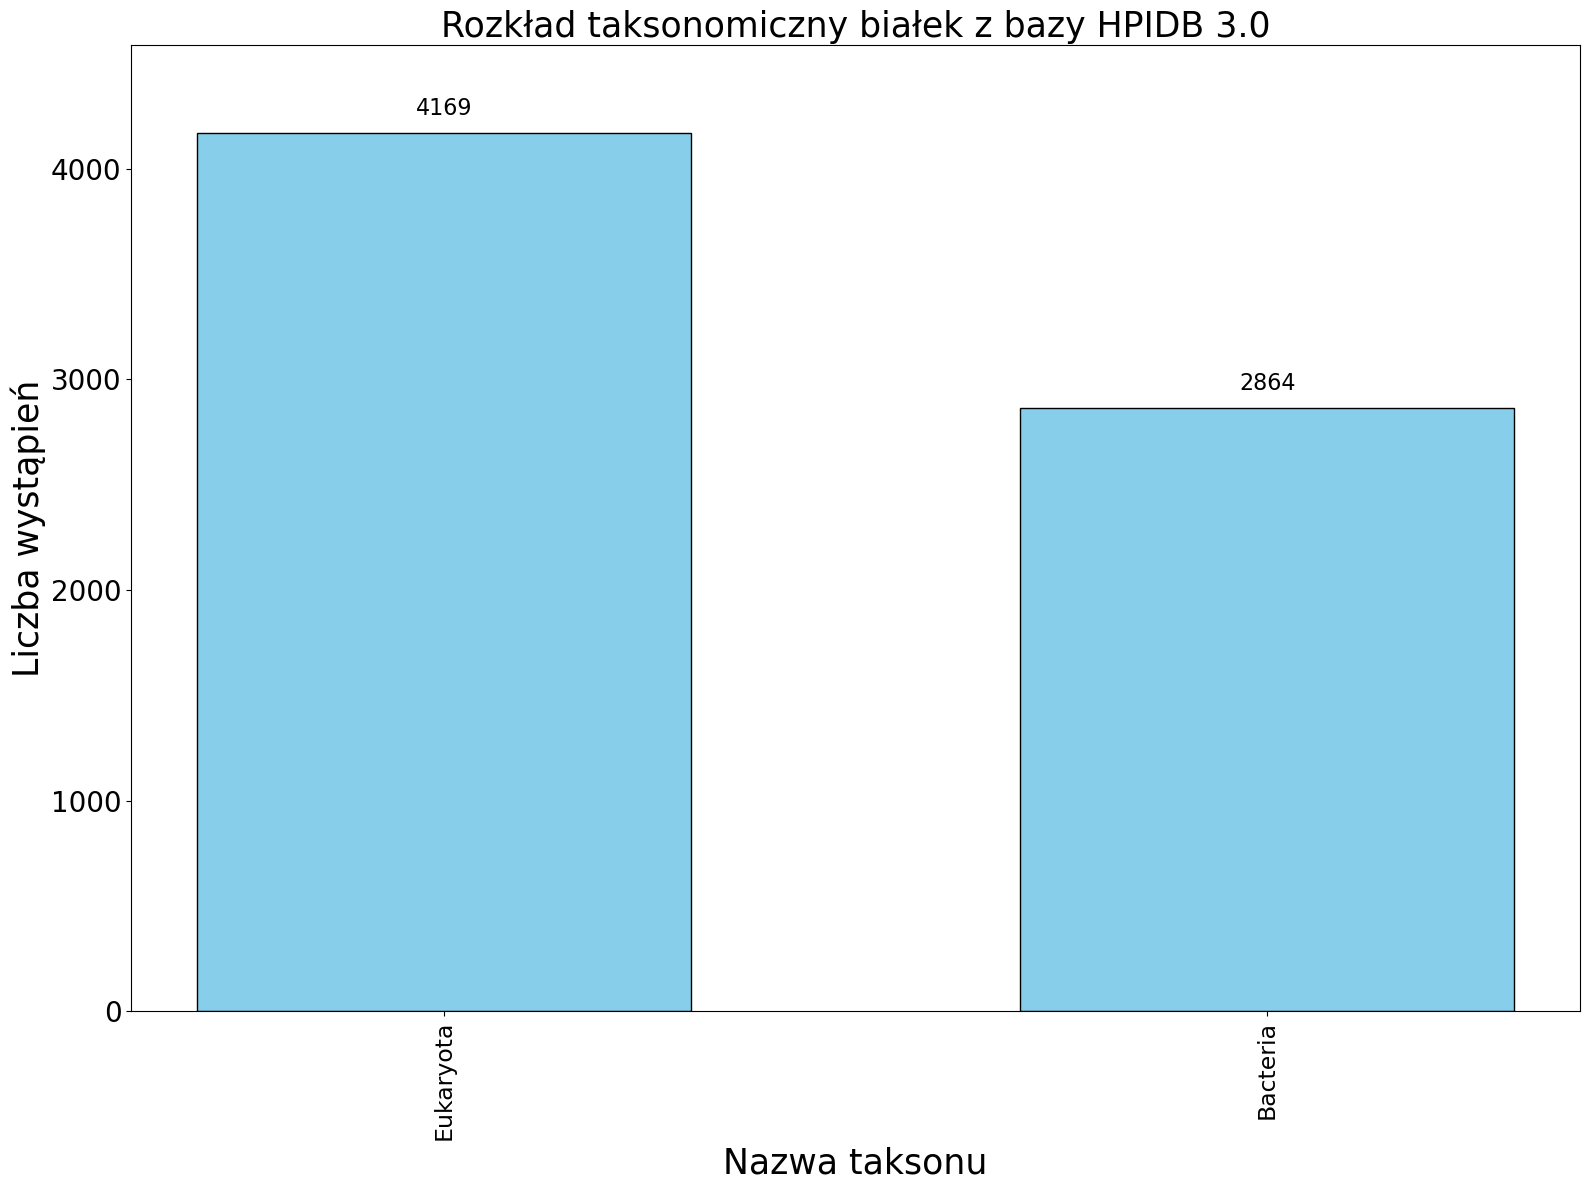

In [13]:
plot_taxonomy(phisto_active_json, "PHISTO", "POL", -1)
plot_taxonomy(phisto_active_json, "PHISTO", "POL", 0)
plot_taxonomy(hpidb3_active_json, "HPIDB 3.0", "POL", -1)
plot_taxonomy(hpidb3_active_json, "HPIDB 3.0", "POL", 0)

### Removing noise in taxonomic data

In [14]:
phisto_active_json = "../datasets/PHISTODB/ID_map/phisto_human_bacteria_id_uniprot_active.json"
phisto_ids_active_file = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot_active.txt"

hosts_phi = {}
path_phi = {}
with open(phisto_active_json, 'r') as i:
    data = json.load(i)
    for record in data['results']:
        if record['to']['organism']['lineage'][0] == 'Bacteria':
            path_phi[record['from']] = record['to']['primaryAccession']
        elif record['to']['organism']['scientificName'] == 'Homo sapiens':
            hosts_phi[record['from']] = record['to']['primaryAccession']
phisto_ids_tax_clean_file = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot_active_tax_clean.txt"
with open(phisto_ids_active_file, 'r') as i, open(phisto_ids_tax_clean_file, 'w') as o:
    for line in i:
        columns = line.strip().split("\t")
        if columns[0] in hosts_phi and columns[1] in path_phi:
            host_acc = hosts_phi[columns[0]]
            path_acc = path_phi[columns[1]]
            o.write(f"{host_acc}\t{path_acc}\n")
print(f"Number of PPI in PHISTO taxonomy cleansed dataset: {rows_count(phisto_ids_tax_clean_file)}")

Number of PPI in PHISTO taxonomy cleansed dataset: 9118


In [15]:
hpidb3_active_json = "../datasets/HPIDB3/ID_map/hpidb3_bacteria_id_uniprot_active.json"
hpidb3_ids_active_file = "../datasets/HPIDB3/IDs_files/hpidb3_bacteria_id_uniprot_active.txt"

hosts_hpidb = {}
path_hpidb = {}
with open(hpidb3_active_json, 'r') as i:
    data = json.load(i)
    for record in data['results']:
        if record['to']['organism']['lineage'][0] == 'Bacteria':
            path_hpidb[record['from']] = record['to']['primaryAccession']
        elif record['to']['organism']['scientificName'] == 'Homo sapiens':
            hosts_hpidb[record['from']] = record['to']['primaryAccession']
hpidb3_ids_tax_clean_file = "../datasets/HPIDB3/IDs_files/hpidb3_human_bacteria_id_uniprot_active_tax_clean.txt"
with open(hpidb3_ids_active_file, 'r') as i, open(hpidb3_ids_tax_clean_file, 'w') as o:
    for line in i:
        columns = line.strip().split("\t")
        if columns[0] in hosts_hpidb and columns[1] in path_hpidb:
            host_acc = hosts_hpidb[columns[0]]
            path_acc = path_hpidb[columns[1]]
            o.write(f"{host_acc}\t{path_acc}\n")
print(f"Number of PPI in HPIDB 3.0 taxonomy cleansed dataset: {rows_count(hpidb3_ids_tax_clean_file)}")

Number of PPI in HPIDB 3.0 taxonomy cleansed dataset: 9442


### Mapping cleaned datasets to JSON and ploting taxonomic info

In [16]:
phisto_tax_clean_json = "../datasets/PHISTODB/ID_map/phisto_human_bacteria_id_uniprot_active_tax_clean.json"
hpidb3_tax_clean_json = "../datasets/HPIDB3/ID_map/hpidb3_human_bacteria_id_uniprot_active_tax_clean.json"
print(f"Number of proteins in taxonomy cleansed PHISTO dataset: {count_json_records(phisto_tax_clean_json)}")
print(f"Number of proteins in taxonomy cleansed HPIDB 3.0 dataset: {count_json_records(hpidb3_tax_clean_json)}")

Number of proteins in taxonomy cleansed PHISTO dataset: 6333
Number of proteins in taxonomy cleansed HPIDB 3.0 dataset: 6501


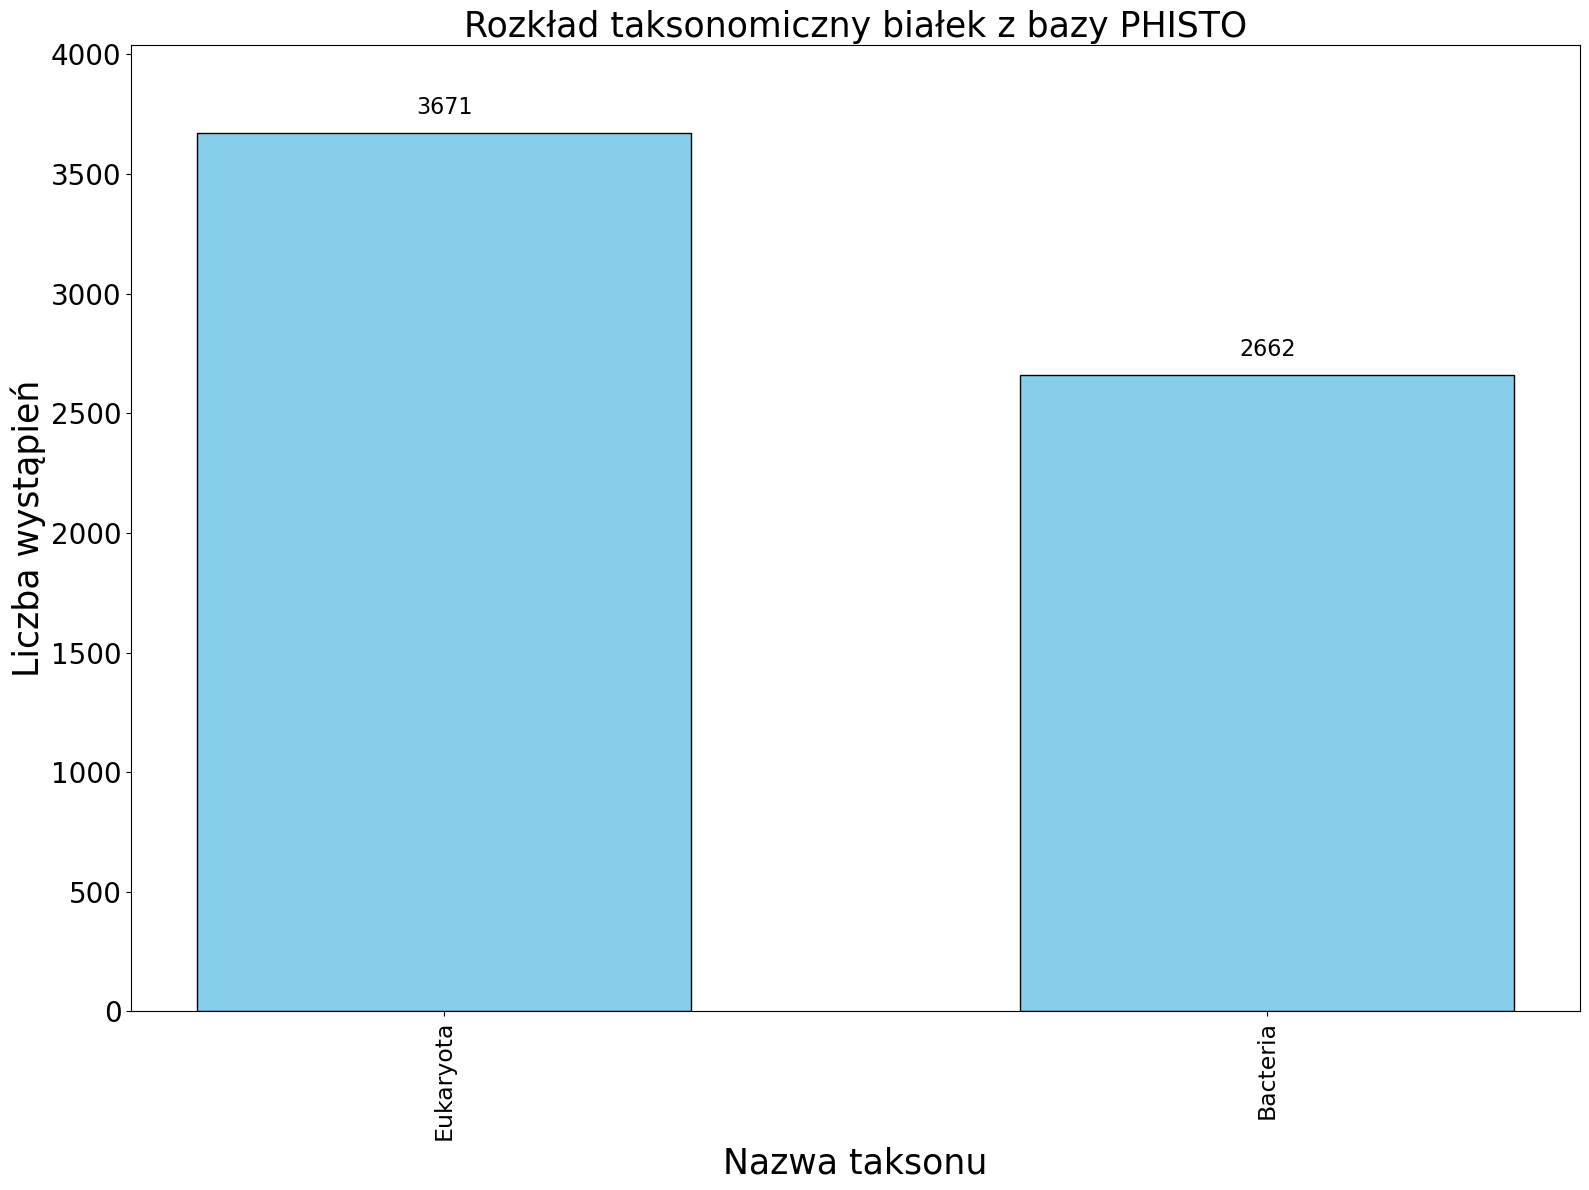

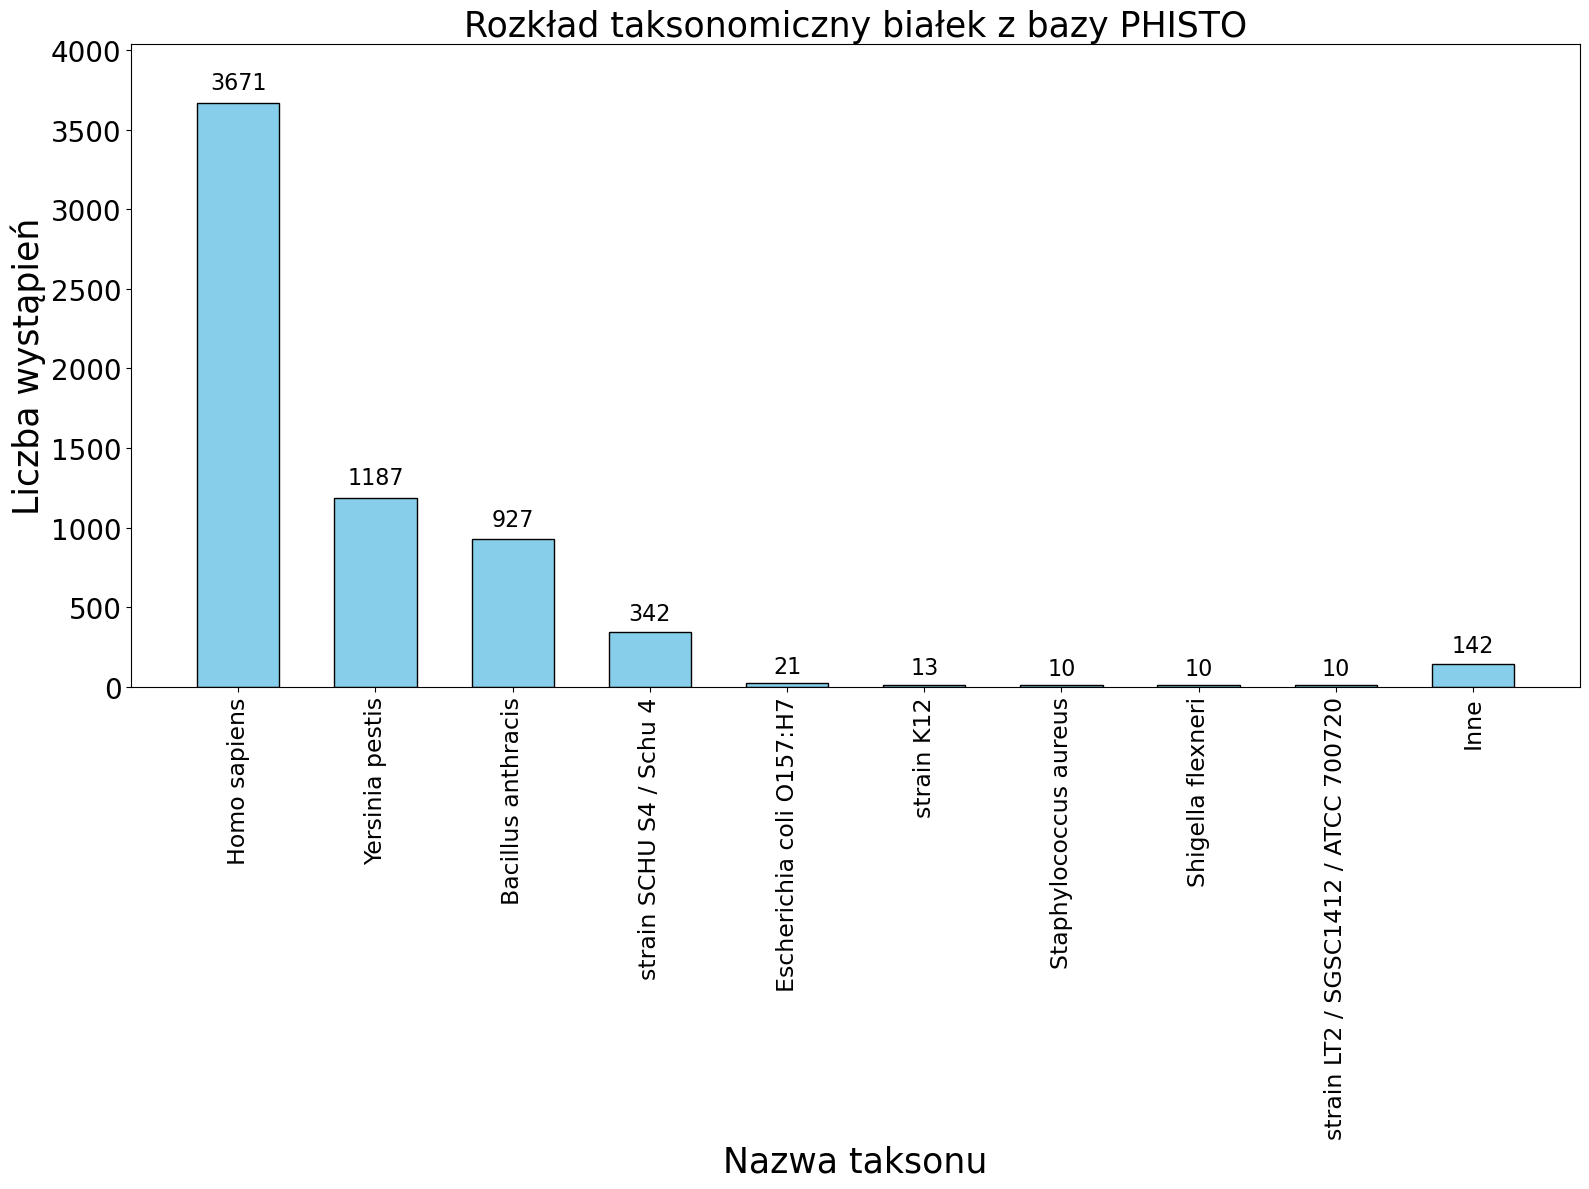

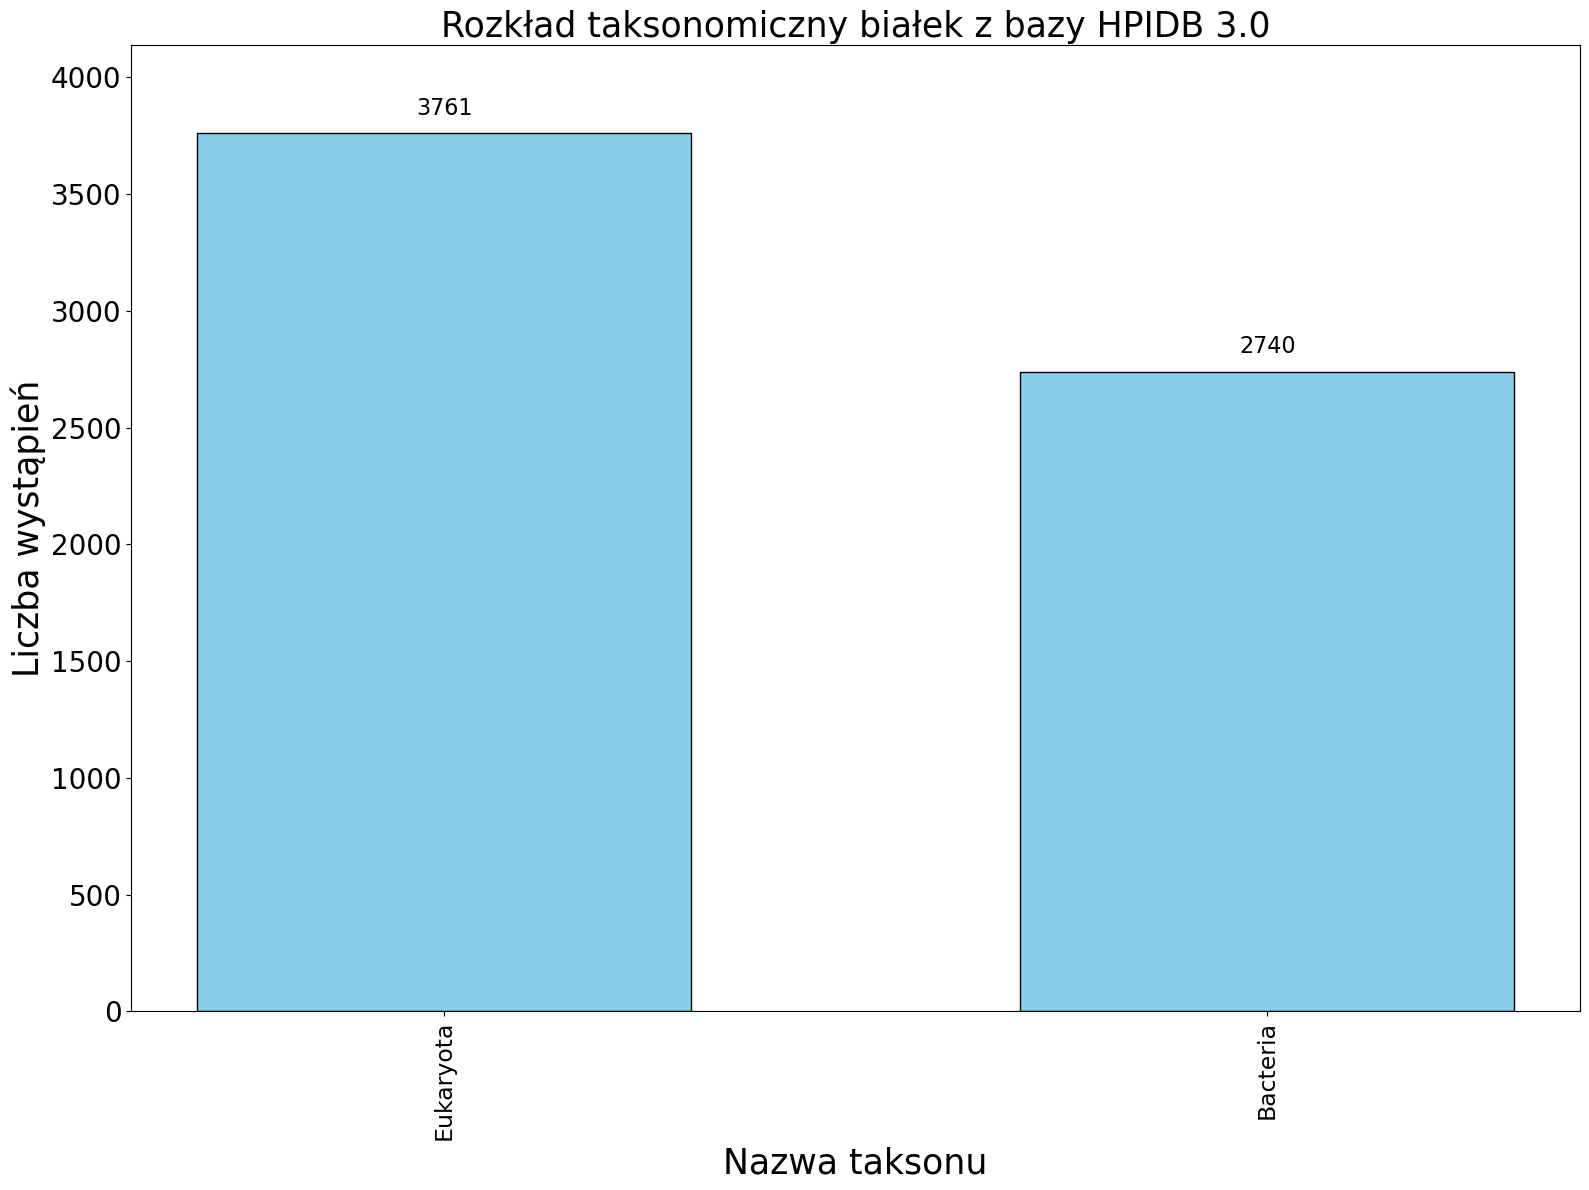

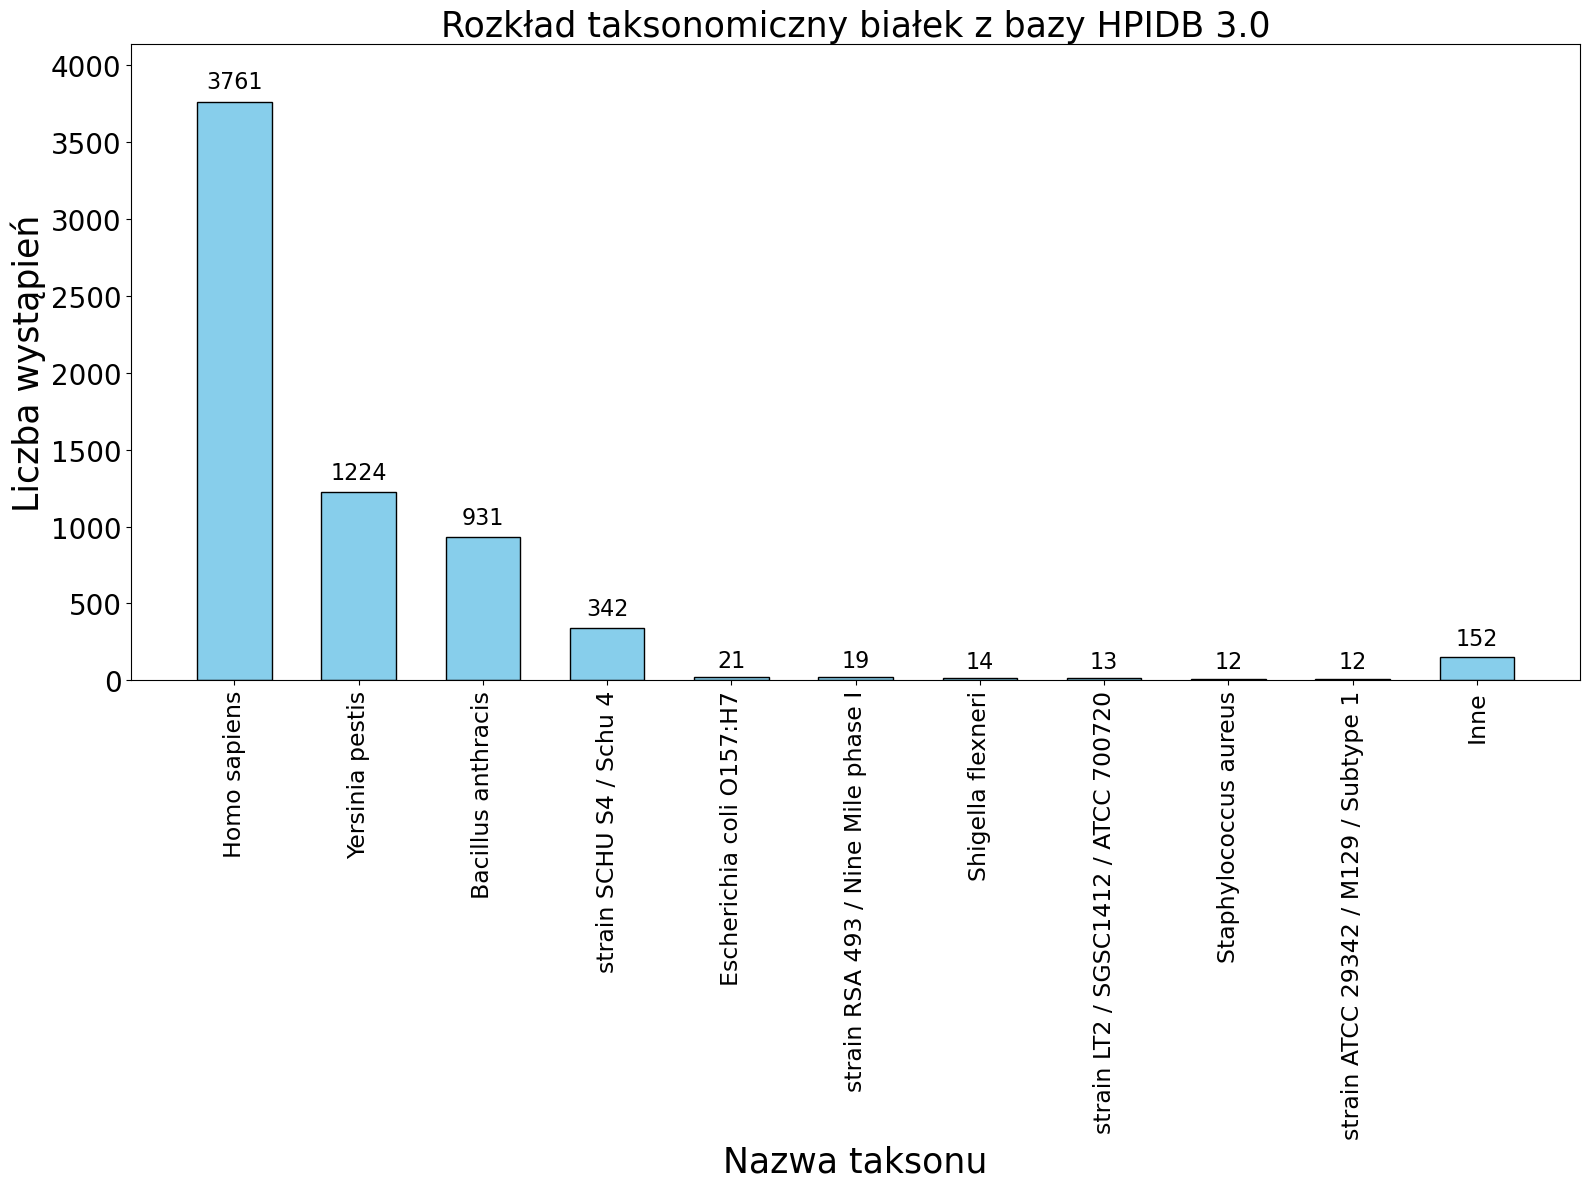

In [17]:
plot_taxonomy(phisto_tax_clean_json, "PHISTO", "POL", 0)
plot_taxonomy(phisto_tax_clean_json, "PHISTO", "POL", -1)
plot_taxonomy(hpidb3_tax_clean_json, "HPIDB 3.0", "POL", 0)
plot_taxonomy(hpidb3_tax_clean_json, "HPIDB 3.0", "POL", -1)

## Redundancy
As we are working with dataset on which we will train our model, redundancy is important factor to consider. It steemed from the impact of redundant dataset on model prediction quality. If we trained model on highly redundant dataset, the model would prioritize some charatceristics, ignoring other. It would cause occurances of false negative predictions.

### Mapping datasets to FASTA

In [18]:
phisto_tax_clean_fasta = "../datasets/PHISTODB/ID_map/phisto_human_bacteria_id_uniprot_active_tax_clean.fasta"
hpidb3_tax_clean_fasta = "../datasets/HPIDB3/ID_map/hpidb3_human_bacteria_id_uniprot_active_tax_clean.fasta"
print(f"Number of proteins in taxonomy cleansed PHISTO dataset: {count_fasta_records(phisto_tax_clean_fasta)}")
print(f"Number of proteins in taxonomy cleansed HPIDB 3.0 dataset: {count_fasta_records(hpidb3_tax_clean_fasta)}")

Number of proteins in taxonomy cleansed PHISTO dataset: 6333
Number of proteins in taxonomy cleansed HPIDB 3.0 dataset: 6501


### Inner redundancy
Firstly we will focus on checking inner-redundancy for each dataset. For this purpose the CD-HIT clustering was used to place similar sequences into groups, of which only the longest is a cluster representative. To perform CD-HIT there was need to map Uniprot ID to thier sequences using "ID mapping" option on Uniprot webserver. The results were downloaded as FASTA files:
**phisto_human_bacteria_id_uniprot_clean_cdhit.fasta** i **hpidb3_human_bacteria_id_uniprot_clean_cdhit.fasta**

In [19]:
phisto_ids_tax_clean_file = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot_active_tax_clean.txt"
hpidb3_ids_tax_clean_file = "../datasets/HPIDB3/IDs_files/hpidb3_human_bacteria_id_uniprot_active_tax_clean.txt"

phisto_tax_clean_fasta_cdhit = "../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit.fasta"
hpidb3_tax_clean_fasta_cdhit = "../datasets/HPIDB3/CD-HIT/hpidb3_human_bacteria_id_uniprot_active_tax_clean_cdhit.fasta"
cd_hit_format(phisto_tax_clean_fasta, phisto_ids_tax_clean_file, phisto_tax_clean_fasta_cdhit)
cd_hit_format(hpidb3_tax_clean_fasta, hpidb3_ids_tax_clean_file, hpidb3_tax_clean_fasta_cdhit)
print(count_fasta_records(phisto_tax_clean_fasta_cdhit))
print(count_fasta_records(hpidb3_tax_clean_fasta_cdhit))

9118
9442


In [20]:
thresholds = [0.5,0.7,0.8,0.9]
#-----------------PHISTO-----------------------------------
for c in thresholds:
    c_str = str(int(c*100))
    output_phisto_file = f"../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit_{c_str}.fasta"
    if c == 0.5:
        !cd-hit -i {phisto_tax_clean_fasta_cdhit} -o {output_phisto_file} -c {c} -n 3 -d 0
    else:
        !cd-hit -i {phisto_tax_clean_fasta_cdhit} -o {output_phisto_file} -c {c} -n 5 -d 0
#-----------------HPIDB3-----------------------------------
for c in thresholds:
    c_str = str(int(c*100))
    output_hpidb3_file = f"../datasets/HPIDB3/CD-HIT/hpidb3_human_bacteria_id_uniprot_active_tax_clean_cdhit_{c_str}.fasta"
    if c == 0.5:
        !cd-hit -i {hpidb3_tax_clean_fasta_cdhit} -o {output_hpidb3_file} -c {c} -n 3 -d 0
    else:
        !cd-hit -i {hpidb3_tax_clean_fasta_cdhit} -o {output_hpidb3_file} -c {c} -n 5 -d 0

Program: CD-HIT, V4.8.1 (+OpenMP), Aug 20 2021, 08:39:56
Command: cd-hit -i
         ../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit.fasta
         -o
         ../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit_50.fasta
         -c 0.5 -n 3 -d 0

Started: Thu Jun 19 23:53:58 2025
                            Output                              
----------------------------------------------------------------
total seq: 9118
longest and shortest : 9394 and 147
Total letters: 11941429
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 13M
Buffer          : 1 X 12M = 12M
Table           : 1 X 0M = 0M
Miscellaneous   : 0M
Total           : 26M

Table limit with the given memory limit:
Max number of representatives: 489977
Max number of word counting entries: 96733374

comparing sequences from          0  to       9118
.........
     9118  finished       2435  clusters

Approximated maxim

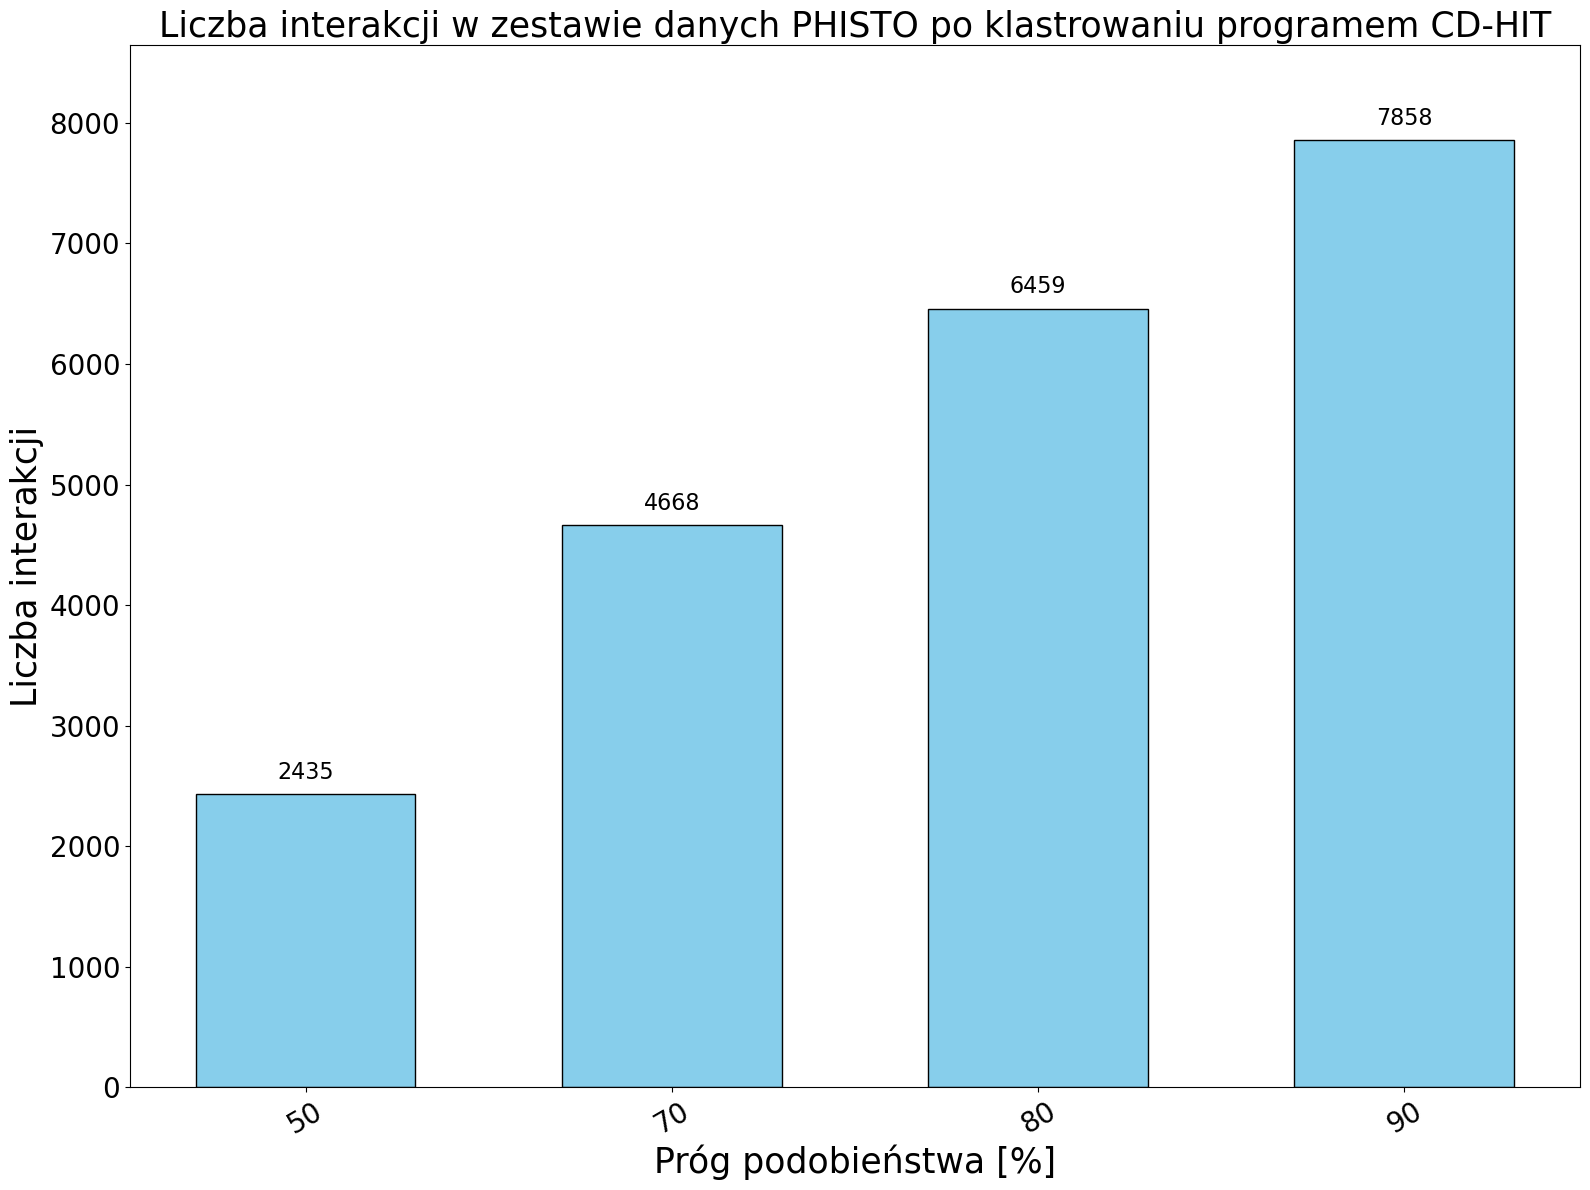

In [21]:
cdhit70_phisto = "../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit_70.fasta"
cdhit80_phisto = "../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit_80.fasta"
cdhit50_phisto = "../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit_50.fasta"
cdhit90_phisto = "../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit_90.fasta"
to_bar_plot(['50','70','80','90'], [count_fasta_records(cdhit50_phisto), count_fasta_records(cdhit70_phisto), count_fasta_records(cdhit80_phisto), count_fasta_records(cdhit90_phisto)], "Liczba interakcji w zestawie danych PHISTO po klastrowaniu programem CD-HIT", "Próg podobieństwa [%]", "Liczba interakcji")

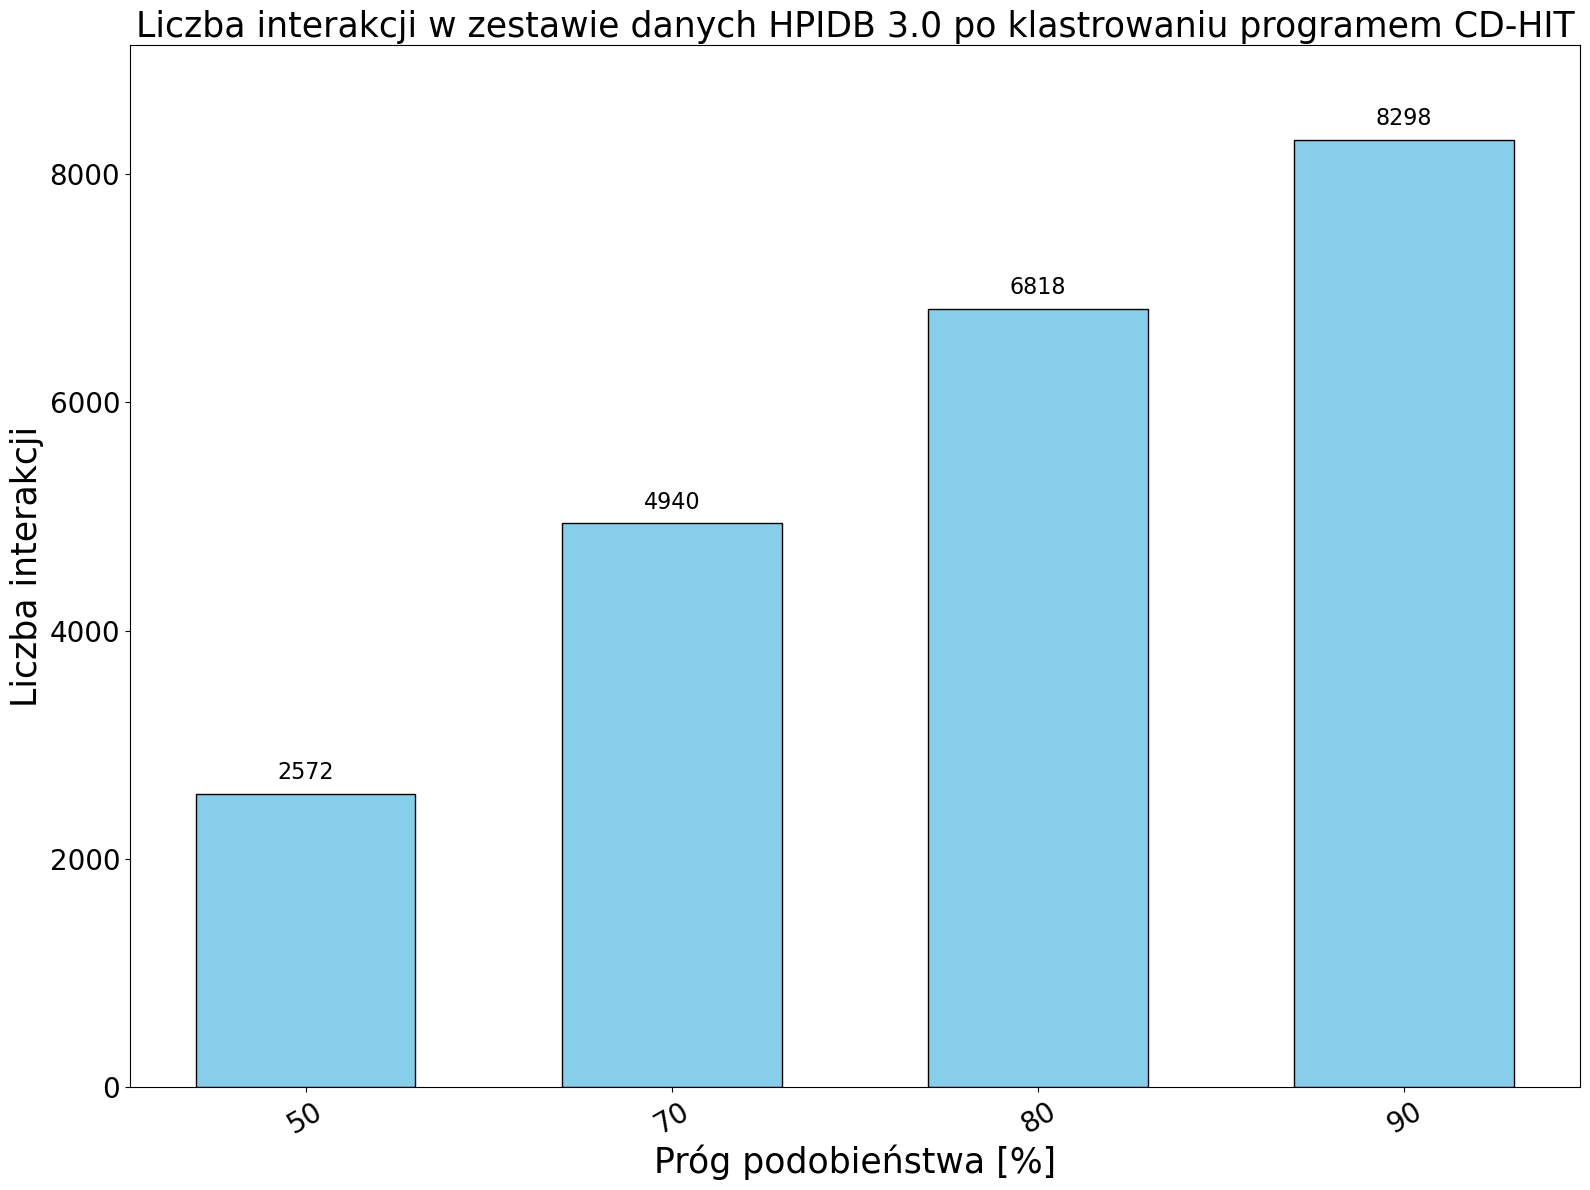

In [22]:
cdhit50_hpidb3 = "../datasets/HPIDB3/CD-HIT/hpidb3_human_bacteria_id_uniprot_active_tax_clean_cdhit_50.fasta"
cdhit70_hpidb3 = "../datasets/HPIDB3/CD-HIT/hpidb3_human_bacteria_id_uniprot_active_tax_clean_cdhit_70.fasta"
cdhit80_hpidb3 = "../datasets/HPIDB3/CD-HIT/hpidb3_human_bacteria_id_uniprot_active_tax_clean_cdhit_80.fasta"
cdhit90_hpidb3 = "../datasets/HPIDB3/CD-HIT/hpidb3_human_bacteria_id_uniprot_active_tax_clean_cdhit_90.fasta"
to_bar_plot(['50','70','80','90'], [count_fasta_records(cdhit50_hpidb3), count_fasta_records(cdhit70_hpidb3), count_fasta_records(cdhit80_hpidb3), count_fasta_records(cdhit90_hpidb3)], "Liczba interakcji w zestawie danych HPIDB 3.0 po klastrowaniu programem CD-HIT", "Próg podobieństwa [%]", "Liczba interakcji")

In [23]:
cdhit70_phisto = "../datasets/PHISTODB/CD-HIT/phisto_human_bacteria_id_uniprot_active_tax_clean_cdhit_70.fasta"
phisto_ids_final_file = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot_final.txt"
with open(cdhit70_phisto, 'r') as i, open(phisto_ids_final_file, 'w') as o:
    for line in i:
        if line.startswith(">"):
            ids = line.strip()[1:]
            if "&" in ids:
                id1,id2 = ids.split("&")
                o.write(f"{id1}\t{id2}\n")
print(f"Number of PPI in PHISTO final dataset: {rows_count(phisto_ids_final_file)}")
#--------------------------------------------------------------------------------------------
cdhit70_hpidb3 = "../datasets/HPIDB3/CD-HIT/hpidb3_human_bacteria_id_uniprot_active_tax_clean_cdhit_70.fasta"
hpidb3_ids_final_file = "../datasets/HPIDB3/IDs_files/hpidb3_human_bacteria_id_uniprot_final.txt"
with open(cdhit70_hpidb3, 'r') as i, open(hpidb3_ids_final_file, 'w') as o:
    for line in i:
        if line.startswith(">"):
            ids = line.strip()[1:]
            if "&" in ids:
                id1,id2 = ids.split("&")
                o.write(f"{id1}\t{id2}\n")
print(f"Number of PPI in HPIDB 3.0 final dataset: {rows_count(hpidb3_ids_final_file)}")

Number of PPI in PHISTO final dataset: 4668
Number of PPI in HPIDB 3.0 final dataset: 4940


### Outer redundancy and merging

In [24]:
phisto_ids_tax_clean_file = "../datasets/PHISTODB/IDs_files/phisto_human_bacteria_id_uniprot_active_tax_clean.txt"
hpidb3_ids_tax_clean_file = "../datasets/HPIDB3/IDs_files/hpidb3_human_bacteria_id_uniprot_active_tax_clean.txt"
merged_ids_file = "../datasets/Merged/merged_ids_file.txt"

print(f"Number of PPI in PHISTO dataset: {rows_count(phisto_ids_tax_clean_file)}")
print(f"Number of PPI in HPIDB 3.0 dataset: {rows_count(hpidb3_ids_tax_clean_file)}")

phi_pairs = set()
hpidb3_pairs = set()
with open(phisto_ids_tax_clean_file, 'r') as p, open(hpidb3_ids_tax_clean_file, 'r') as h:
    for line in p:
        columns = line.strip().split("\t")
        phi_pairs.add((columns[0], columns[1]))
    for line in h:
        columns = line.strip().split("\t")
        hpidb3_pairs.add((columns[0], columns[1]))
merged_pairs = phi_pairs.union(hpidb3_pairs)
with open(merged_ids_file, 'w') as o:
    for pair in merged_pairs:
        o.write(f"{pair[0]}\t{pair[1]}\n")
print(f"Number of PPI in merged dataset: {rows_count(merged_ids_file)}")

Number of PPI in PHISTO dataset: 9118
Number of PPI in HPIDB 3.0 dataset: 9442
Number of PPI in merged dataset: 9409


Program: CD-HIT, V4.8.1 (+OpenMP), Aug 20 2021, 08:39:56
Command: cd-hit -i
         ../datasets/Merged/CD-HIT/merged_ids_file_cdhit.fasta
         -o
         /content/drive/MyDrive/Protein-Protein_Interaction_Prediction_Project/Datasets/Merged/CD-HIT/merged_ids_file_cdhit_50.fasta
         -c 0.5 -n 3 -d 0

Started: Fri Jun 20 00:10:02 2025
                            Output                              
----------------------------------------------------------------
total seq: 9409
longest and shortest : 9394 and 147
Total letters: 12190385
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 13M
Buffer          : 1 X 12M = 12M
Table           : 1 X 0M = 0M
Miscellaneous   : 0M
Total           : 26M

Table limit with the given memory limit:
Max number of representatives: 491970
Max number of word counting entries: 96696416

comparing sequences from          0  to       9409
.........
     9409  finished       2595  clusters

Approximated maximum me

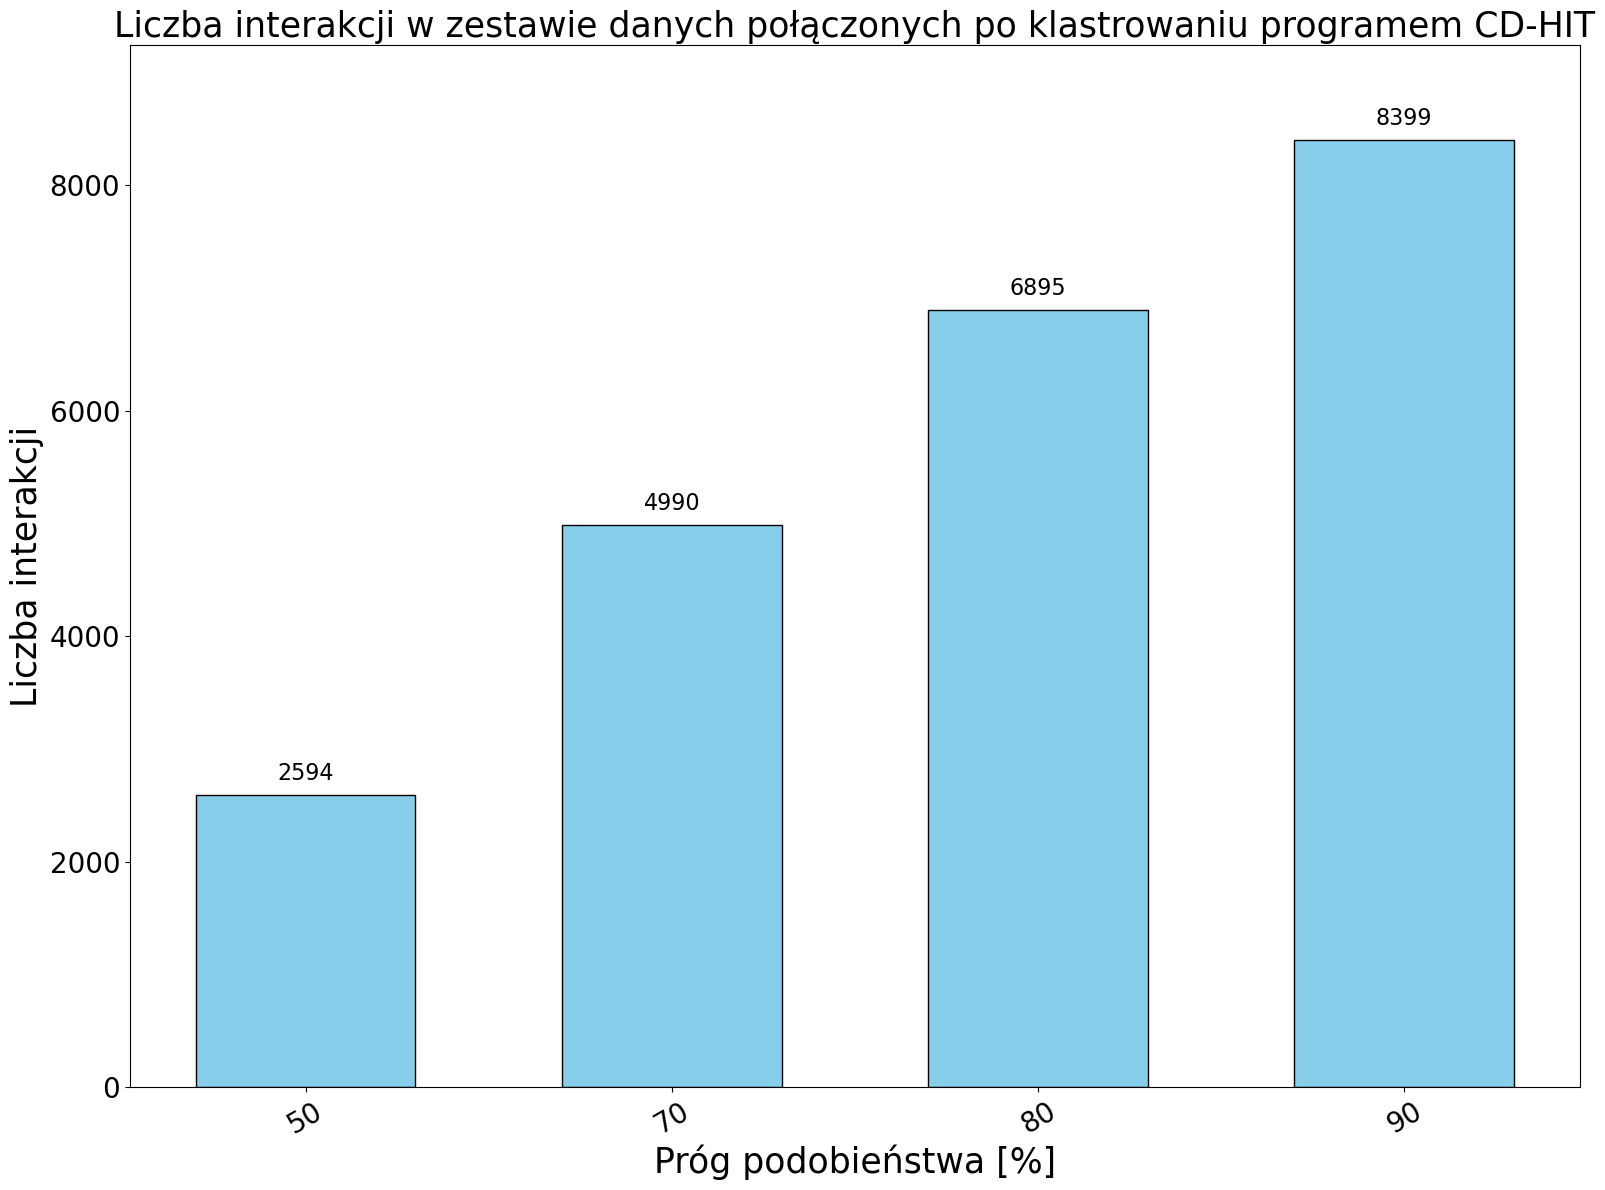

Number of PPI in merged clustered dataset: 4990


In [25]:
#merge_ids_file -> Uniprot ID Mapping -> merge_fasta
merged_fasta = "../datasets/Merged/merged_ids_file.fasta"
merged_fasta_cdhit = "../datasets/Merged/CD-HIT/merged_ids_file_cdhit.fasta"
cd_hit_format(merged_fasta, merged_ids_file, merged_fasta_cdhit)

thresholds = [0.5,0.7,0.8,0.9]
for c in thresholds:
    c_str = str(int(c*100))
    output_merged_file = f"/content/drive/MyDrive/Protein-Protein_Interaction_Prediction_Project/Datasets/Merged/CD-HIT/merged_ids_file_cdhit_{c_str}.fasta"
    if c == 0.5:
        !cd-hit -i {merged_fasta_cdhit} -o {output_merged_file} -c {c} -n 3 -d 0
    else:
        !cd-hit -i {merged_fasta_cdhit} -o {output_merged_file} -c {c} -n 5 -d 0
cdhit50_merged = "../datasets/Merged/CD-HIT/merged_ids_file_cdhit_50.fasta"
cdhit70_merged = "../datasets/Merged/CD-HIT/merged_ids_file_cdhit_70.fasta"
cdhit80_merged = "../datasets/Merged/CD-HIT/merged_ids_file_cdhit_80.fasta"
cdhit90_merged = "../datasets/Merged/CD-HIT/merged_ids_file_cdhit_90.fasta"

to_bar_plot(['50','70','80','90'], [count_fasta_records(cdhit50_merged), count_fasta_records(cdhit70_merged), count_fasta_records(cdhit80_merged), count_fasta_records(cdhit90_merged)], "Liczba interakcji w zestawie danych połączonych po klastrowaniu programem CD-HIT", "Próg podobieństwa [%]", "Liczba interakcji")
merged_clustered_ids_file = "../datasets/Merged/merged_clustered_ids_file.txt"
with open(cdhit70_merged, 'r') as i, open(merged_clustered_ids_file, 'w') as o:
    for line in i:
        if line.startswith(">"):
            ids = line.strip()[1:]
            if "&" in ids:
                id1,id2 = ids.split("&")
                o.write(f"{id1}\t{id2}\n")
print(f"Number of PPI in merged clustered dataset: {rows_count(merged_clustered_ids_file)}")

## Final datasets analysis
Last section in this notebook is devoted to issues such as:


1.   Taxonomy raport for merged dataset
2.   Analysing changes in the number of interactions in datasets throughout the analysis


### Merged dataset taxonomy analysis

Number of proteins in merged clustered dataset: 5499
Number of proteins in merged clustered dataset: 5499


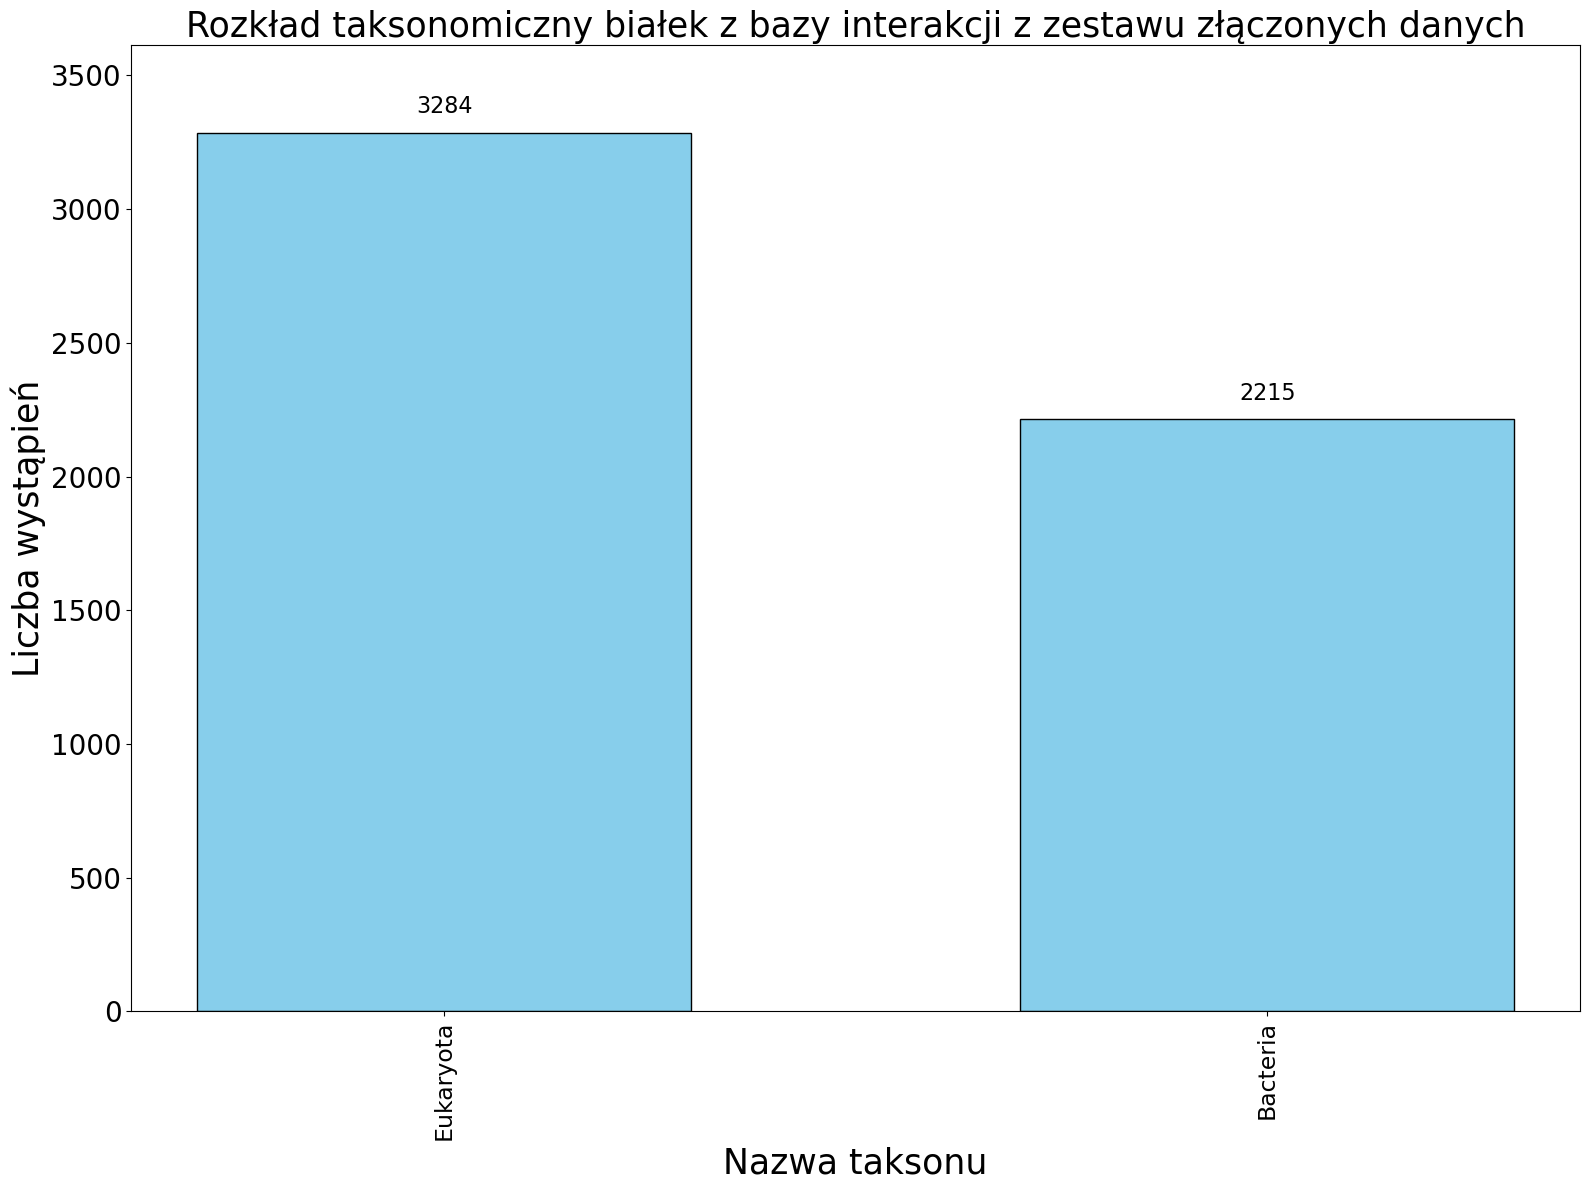

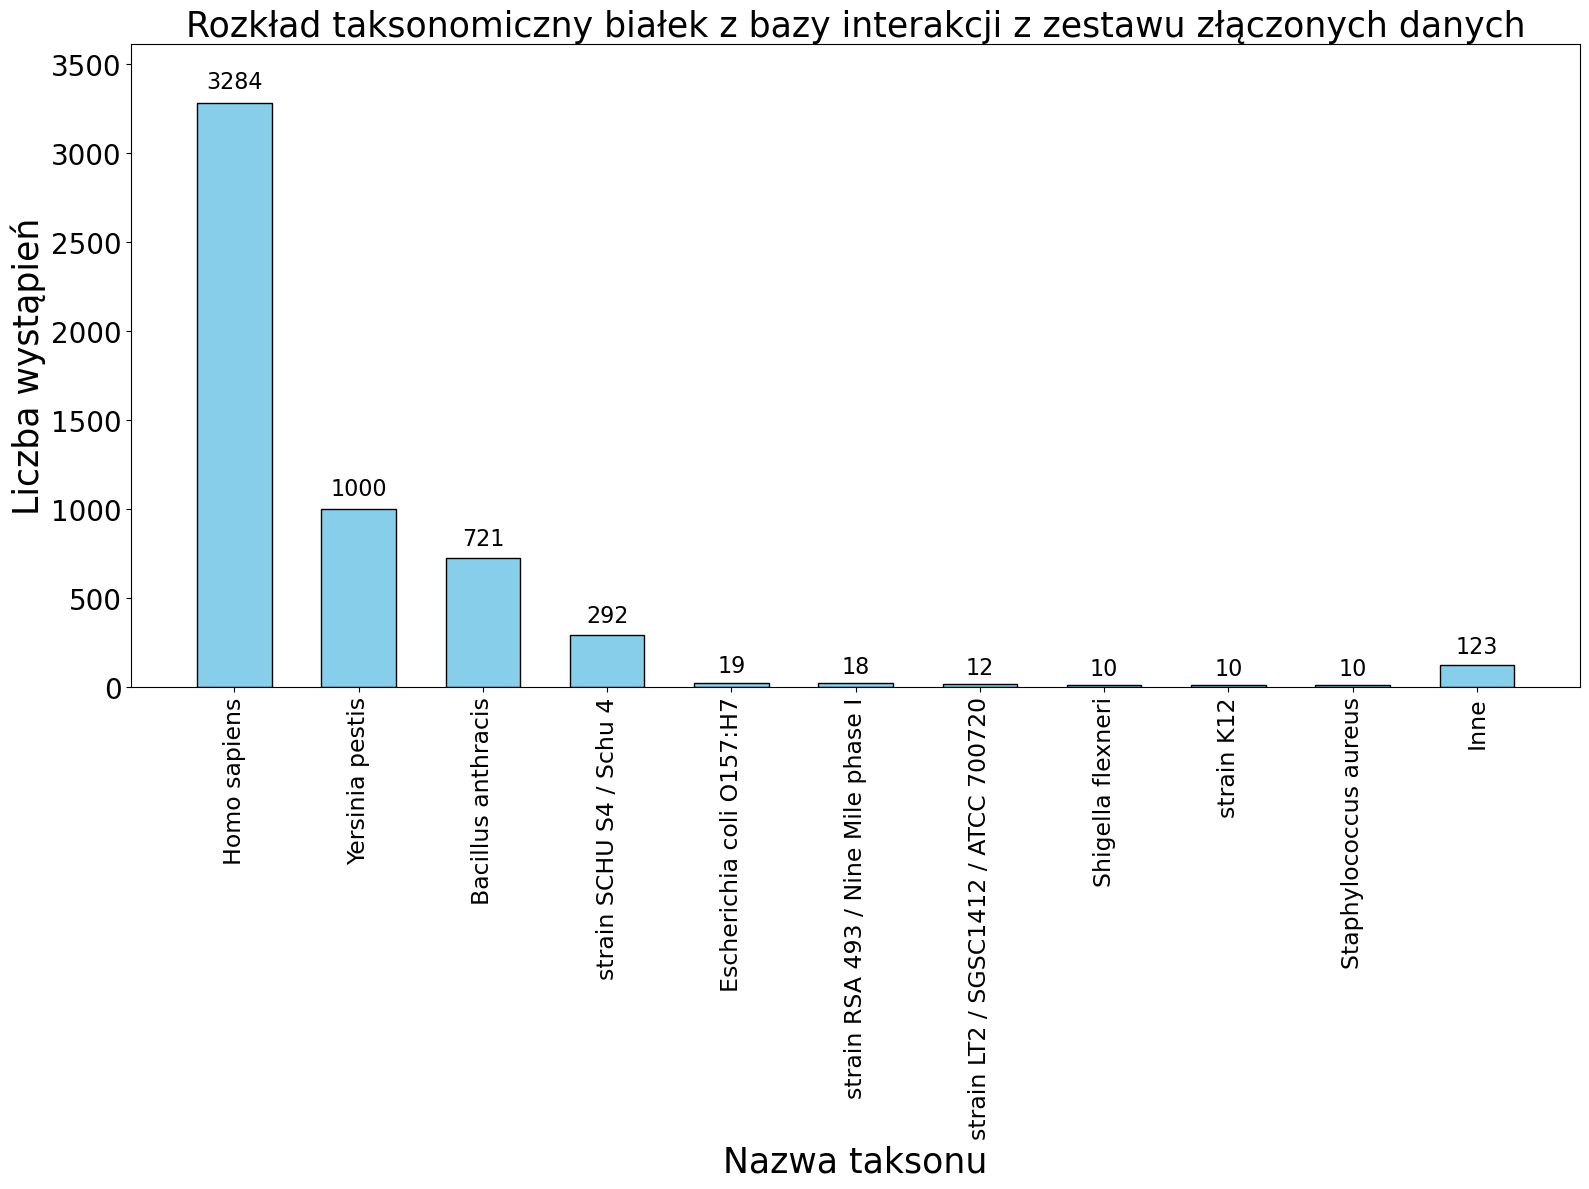

In [26]:
merged_clustered_ids_file = "../datasets/Merged/merged_clustered_ids_file.txt"
merge_clustered_fasta = "../datasets/Merged/merged_clustered_ids_file.fasta"
merge_clustered_json = "../datasets/Merged/merged_clustered_ids_file.json"

print(f"Number of proteins in merged clustered dataset: {count_fasta_records(merge_clustered_fasta)}")
format_json(merge_clustered_json)
print(f"Number of proteins in merged clustered dataset: {count_json_records(merge_clustered_json)}")

plot_taxonomy(merge_clustered_json, "interakcji z zestawu złączonych danych", "POL", 0)
plot_taxonomy(merge_clustered_json, "interakcji z zestawu złączonych danych", "POL", -1)

### Analysis of the length of PHISTO and HPIDB 3.0 datasets

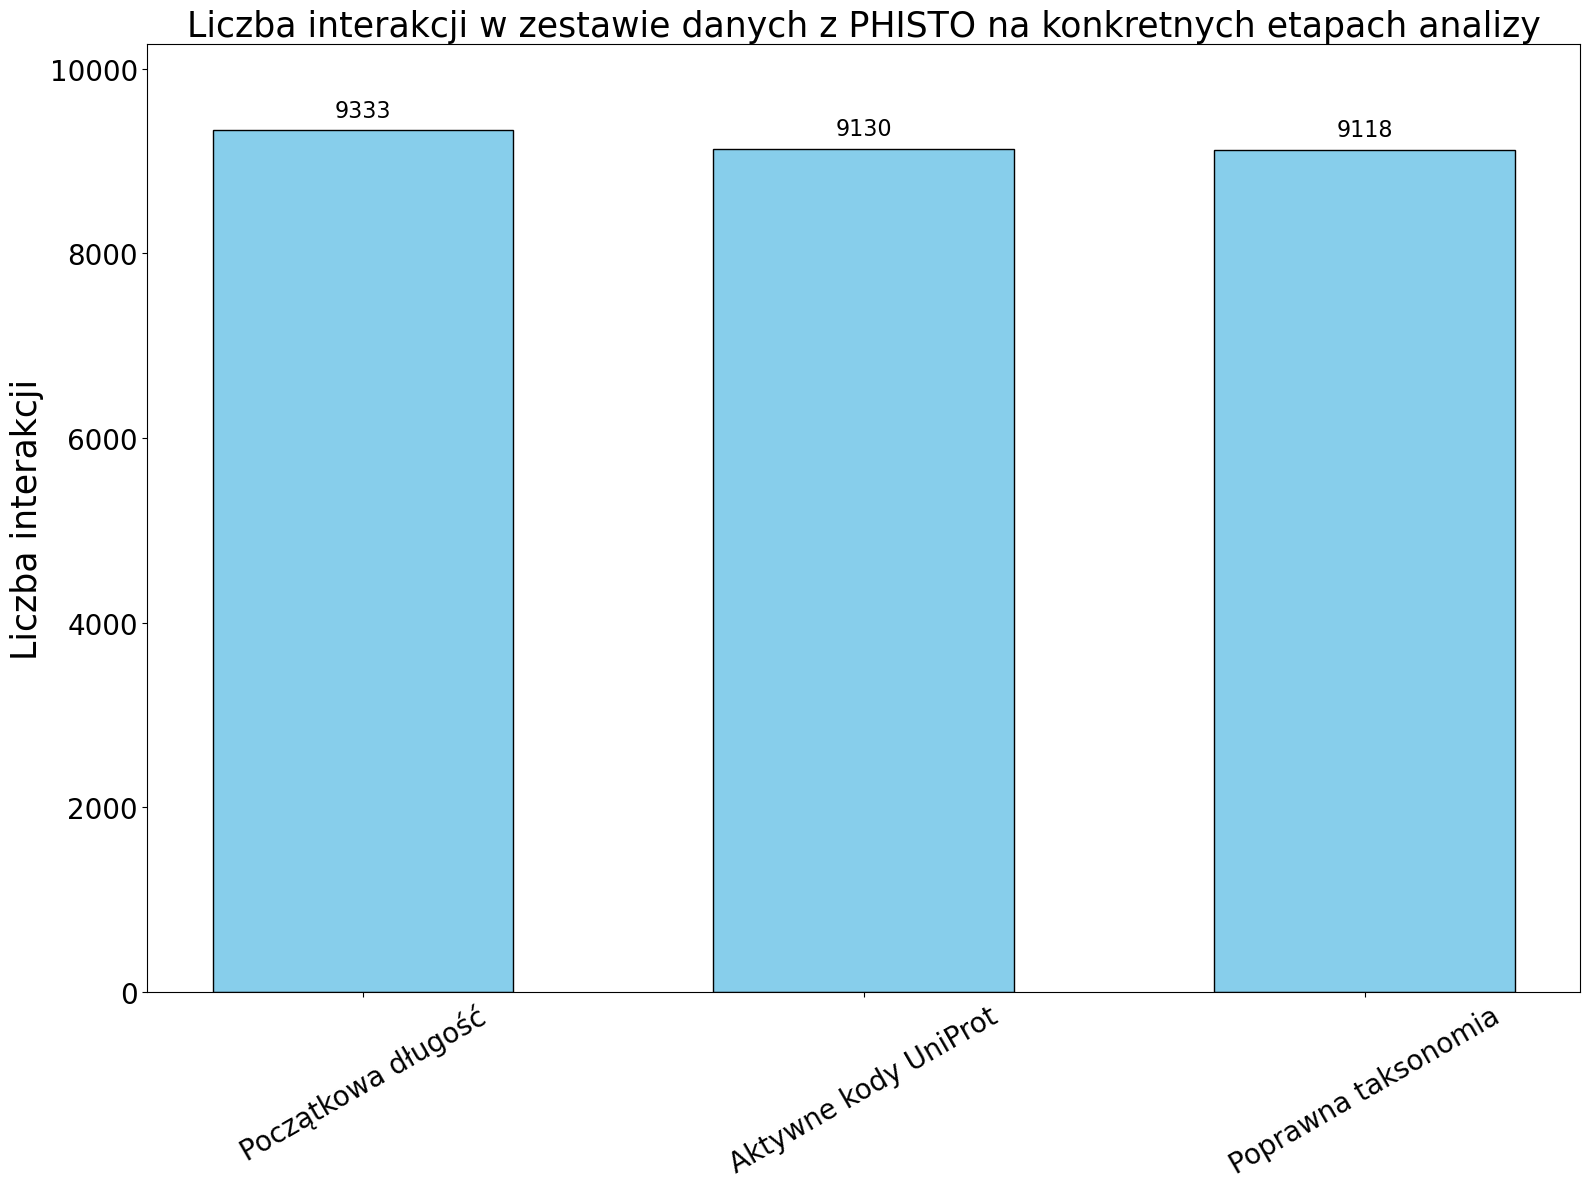

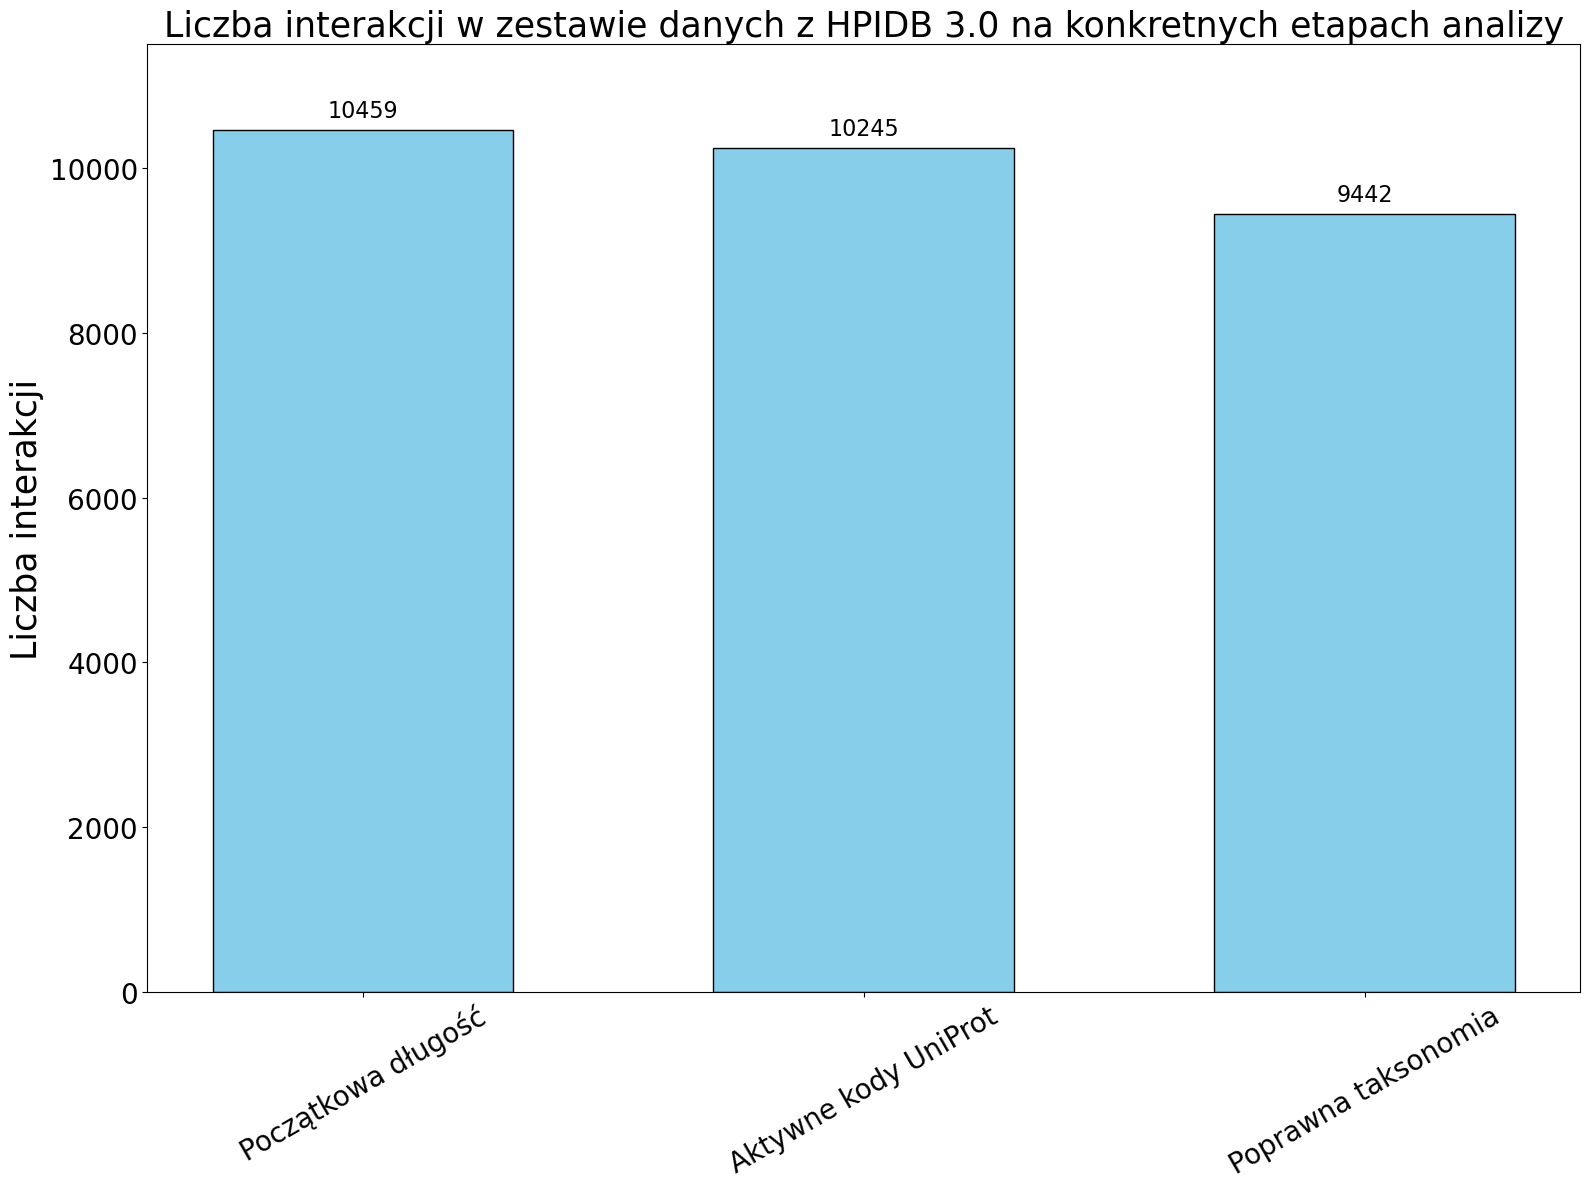

In [27]:
to_bar_plot(
    ["Początkowa długość", "Aktywne kody UniProt", "Poprawna taksonomia"],
    [rows_count(phisto_ids_file), rows_count(phisto_ids_active_file), rows_count(phisto_ids_tax_clean_file)],
    "Liczba interakcji w zestawie danych z PHISTO na konkretnych etapach analizy",
    "",
    "Liczba interakcji"
)
to_bar_plot(
    ["Początkowa długość", "Aktywne kody UniProt", "Poprawna taksonomia"],
    [rows_count(hpidb3_ids_file), rows_count(hpidb3_ids_active_file), rows_count(hpidb3_ids_tax_clean_file)],
    "Liczba interakcji w zestawie danych z HPIDB 3.0 na konkretnych etapach analizy",
    "",
    "Liczba interakcji"
)

### Generating taxonomy raport for proteins of bacterial pathogens from merged dataset
This step of analysis was conducted by using MMseqs2 tool and Pavian website.
Proteins of bacterial pathogens were isolated from human proteins using taxonomy ID filter available on Uniprot website.

In [28]:
merged_clustered_fasta_pathogens = "../datasets/Merged/merged_clustered_ids_pathogens_file.fasta"
print(f"Number of proteins of bacterial pathogens in merged clustered dataset: {count_fasta_records(merged_clustered_fasta_pathogens)}")

Number of proteins of bacterial pathogens in merged clustered dataset: 2215


Due to the problems to conduct MMseq2 in Google Colab it was decided to perform the algorithm in bash terminal on Ubuntu os with following commands:

```
conda install -c conda-forge -c bioconda mmseqs2

mmseqs databases UniProtKB/Swiss-Prot swissprot tmp
mmseqs createdb datasets/merged_clustered_ids_pathogens_file.fasta merged_db

mmseqs taxonomy merged_db swissprot taxonomyResult_merged tmp

mmseqs taxonomyreport swissprot taxonomyResult_merged taxonomyResult_merged_report
```

Generated report file was then uploaded to [Pavian webstie](https://fbreitwieser.shinyapps.io/pavian/).